# Modelo de seis vértices [Modelo KDP] (Algoritmo de bucles, Barkeman y Newman)

In [1]:
import numpy as np
import math as m
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from collections import deque
import time
from matplotlib.patches import Patch

class SixVertexModelArrows:
    def __init__(self, L, pasos_eq=1000, mc_pasos=100):
        """
        __init__ Inicializa la retícula ajustada a ciertos parámetros como el tamaño, los pasos de equilibrio y los pasos Monte Carlo
    
        :self.L: Es el tamaño del lado de la retícula (cuadrada)
        :self.pasos_eq: Es el número de pasos para que la retícula alcance el equilibrio termodinamico
        :self.mc_pasos: Es el número de pasos Monte Carlo utilizados para tomar estadística de las variables termodinámicas del sistema
        :self.normal: Es un factor de normalización para tomar estadística
        :self.v1: Tipo de vértice del modelo representado con un vector de cuatro entradas
        :self.vertices: Array que contiene a todos los vértices del modelo
        :self.indice: Elige uno de los dos tipos de vértices para inicializar la lattice
        :self.lattice: Inicializa la retícula con un estado base del modelo (solo vértices v1 o solo v2)
        :self.energia_vertice: Energias correspondientes a cada vértice por orden en el array
        """
        self.L = L
        self.N = L * L
        self.pasos_eq = pasos_eq    
        self.mc_pasos = mc_pasos   
        self.normal = 1.0 /(self.N * self.mc_pasos)   
        #La estructura de un vértice es [up, down, left, right]; +1 = flecha hacia afuera, -1 = flecha hacia adentro; Basada en la representacion de Baxter 
        self.v1 = np.array([1,-1,-1,1])
        self.v2 = np.array([-1,1,1,-1])
        self.v3 = np.array([-1,1,-1,1])
        self.v4 = np.array([1,-1,1,-1])
        self.v5 = np.array([1,1,-1,-1])
        self.v6 = np.array([-1,-1,1,1])
        self.vertices = np.array([self.v1, self.v2, self.v3, self.v4, self.v5, self.v6])
        #Inicialización de la lattice para KDP en un ground state (vertices 1 o 2)
        self.indice = np.random.choice([0,1]) 
        self.lattice = np.full((L, L, 4), self.vertices[self.indice]) #Creamos la lattice con un ground state (v1 o v2)
        self.energia_vertice = np.array([0,0,1,1,1,1]) 
        
    def seleccionar_sitio(self): 
        """
        seleccionar_sitio selecciona y retorna un sitio (coordenadas) de la lattice aleatoriamente
        :x: Coordenada x en la retícula seleccionada de manera aleatoria
        :y: Coordenada y en la retícula seleccionada de manera aleatoria
        """
        x = int(np.ceil(np.random.random() * self.L)) - 1
        y = int(np.ceil(np.random.random() * self.L)) - 1
        return x, y
    
    def eleccion_flecha(self, x, y, lattice, indice=None):
        """
        eleccion_flecha es una función que escoge aleatoriamente una de las dos flechas "hacia afuera" (+1) del vértice y retorna sus coordenadas y la de su dirección vecina
        :return: Retornamos tuplas correspondientes a las coordenadas y la flecha afectadas por el movimiento del algoritmo así como el de su vecino que también se ve afectado
        """
        
        bolsa_out = [] #Bolsa de flechas "out"
        for i in range(4): 
            if lattice[x, y, i] == 1 and (indice is None or i != indice): #Verificamos que no sea un indice previamente elegido para el cambio
                bolsa_out.append(i) #Agregamos los indices de flechas "out"
        indice_elegido = np.random.choice(bolsa_out) 
        finv = (x , y, indice_elegido) #Creamos una tupla con las coordenadas del vertice elegido y el indice de su flecha
        
        if finv[-1] == 0:
            fvec = ((x-1) % self.L, y, 1)
        elif finv[-1] == 1:
            fvec = ((x+1) % self.L, y, 0)
        elif finv[-1] == 2:
            fvec = (x, (y-1) % self.L, 3)
        else:
            fvec = (x, (y+1) % self.L, 2)
        
        direcciones = [
        ((x-1) % self.L, y, 1),  # i=0
        ((x+1) % self.L, y, 0),  # i=1
        (x, (y-1) % self.L, 3),  # i=2
        (x, (y+1) % self.L, 2)   # i=3
        ]
        fvec = direcciones[indice_elegido] #Dependiendo del índice elegido creamos una tupla para el vértice vecino afectado con índice opuesto
        return finv, fvec
        
    def loop_algorithm(self, x, y):
        """
        loop_algorithm es una función que crea un loop en base a defectos en vértices aleatorios
        :return: Retornamos una lista con los vértices del loop y todos los vecinos afectados por los cambios
        """
        loop = [] #Lista de los vértices en el loop
        vecinos = [] #Lista de los vértices vecinos afectados por el loop
        latac = self.lattice.copy() #Copia de la lattice para tener una trazabilidad de los cambios en las flechas sin afectar a la lattice original
        noloop = True #Valor que determinará si el loop se ha completado
        opuestos = {0: 1, 1: 0, 2: 3, 3: 2} #Diccionario para asignar los indices opuestos a cada índice de vértice
        
        finv, fvec = self.eleccion_flecha(x,y,latac) #Dadas unas coord. iniciales elegimos una flecha "out"
        x0, y0, i0 = finv #Extraemos valores de la primera flecha invertida
        vx, vy, iv = fvec #Extraemos valores de la primera flecha vecina afectada
        latac[x0, y0, i0] *= -1 #Hacemos los cambios en la lattice copia
        latac[vx, vy, iv] *= -1
        loop.append(finv) #Agregamos las tuplas a las listas loop y vecinos
        vecinos.append(fvec)
        while noloop: #Mientras noloop sea True
            finv, fvec = self.eleccion_flecha(vx, vy, latac, indice=iv) #Elegimos una flecha "out" que no sea la anterior basada en las coord. del vecino anteriormente afectado
            loop.append(finv) #Agregamos a las listas
            vecinos.append(fvec)
            latac[finv[0], finv[1], finv[2]] *= -1 #Hacemos los cambios en la copia
            latac[fvec[0], fvec[1], fvec[2]] *= -1
                    
            if fvec[0] == x and fvec[1] == y and fvec[2] == opuestos[i0]:#Verificamos si hemos terminado el loop
                noloop = False
           
            vx, vy, iv = fvec #Actualizamos las coord. del vertice vecino
        return loop, vecinos        
   
    def voltear_flechas(self, loop):
        """
        voltear_flechas invierte las flechas del loop formado y la de sus vecinos afectados
        """
        for x, y, i in loop:
            self.lattice[x, y, i] *= -1
            if i == 0:
                self.lattice[(x-1) % self.L, y, 1] *= -1
            elif i == 1:
                self.lattice[(x+1) % self.L, y, 0] *= -1
            elif i == 2:
                self.lattice[x, (y-1)% self.L, 3] *= -1
            else:
                self.lattice[x, (y+1) % self.L, 2] *= -1
    
    def verificar_regla_hielo(self): 
        """
        verificar_regla_hielo comprueba que se cumpla la regla de hielo en cada vértice de la lattice
        """
        for x in range(self.L):
            for y in range(self.L):
                if np.sum(self.lattice[x,y] == 1) != 2:
                    raise ValueError(f"Vértice ({x},{y}) viola la regla de hielo")
        #print("¡Todos los vértices cumplen la regla de hielo!")
    
    def graficar_lattice(self, T=None, dpi=100):
        """
        graficar_lattice toma el estado actual de la retícula y la grafica con colores blanco y negro para cada valor de espín
        :T: Temperatura actual del sistema
        :dpi: Resolución de la imagen (Dots per inch)
        """
        mapeo = {
            tuple(self.v1): 1,
            tuple(self.v2): 2,
            tuple(self.v3): 3,
            tuple(self.v4): 4,
            tuple(self.v5): 5,
            tuple(self.v6): 6
        }
        lat = self.lattice.copy()
        lattice_numeros = np.zeros((self.L, self.L), dtype=int)
        for x in range(self.L):
            for y in range(self.L):
                vertice = tuple(lat[x, y])
                lattice_numeros[x, y] = mapeo.get(vertice)
        colores = ['#FF0000', '#00FF00', '#0000FF', '#FF00FF', '#00FFFF', '#FFFF00']        
        fig = plt.figure(figsize=(3, 3), dpi=dpi)
        cmap = ListedColormap(colores)
        
        #leyenda_elementos = [Patch(color=colores[i], label=f'Tipo {i+1} ({list(mapeo.keys())[i]})') for i in range(0,6)]
        
        plt.imshow(lattice_numeros, cmap=cmap, interpolation='none', vmin=1, vmax=6)
        plt.xticks([])
        plt.yticks([])
        plt.grid(True, which='both', color='black', linestyle='--', linewidth=0.5)
        plt.title("Modelo de 6 Vértices - Representación de cada vértice por colores")
        #plt.legend(handles=leyenda_elementos, bbox_to_anchor=(1.25, 1), loc='upper left', title="Configuraciones")
        plt.tight_layout()
        plt.show()
        #plt.close(fig)  # Evita que se muestren las figuras individualmente
        #return fig
        
    def energia_total(self):
        """
        energia_total calcula la energia total de la retícula
        :return: Energia total de la retícula
        """
        e = 0
        lattice_vertices = np.zeros((self.L, self.L), dtype=int)
        for i in range(self.L):
            for j in range(self.L):
                for n, vertice in enumerate(self.vertices):
                    if np.all(self.lattice[i, j] == vertice):
                        lattice_vertices[i,j] = n
        for x in range(self.L):
            for y in range(self.L):
                for n in range (6):
                    if np.all(lattice_vertices[x,y] == n):
                        e += self.energia_vertice[n]
        return e   

    def energia_loop(self, loop, vecinos):
        """
        energia_loop calcula el cambio de energía que ocurre en un loop completo
        :loop: Lista que representa al loop con los cambios
        :vecinos: Lista de los vecinos afectados
        :return: Cambio de energia dependiendo el tipo de movimiento o defecto en el vértice
        """
        l, m, n = 0, 0, 0 #Inicializamos el número de vértices modificados (existen 3 tipos de movimientos)
        clat = self.lattice.copy() #Hacemos una copia de la retícula
        for i in range(len(loop)):#Condiciones para el tipo de movimiento
            x, y, inicio = vecinos[i-1]
            lx, ly, fin = loop[i]
            if (clat[x, y] == self.v1).all() or (clat[x, y] == self.v2).all():
                l +=1
            elif (clat[x, y] == self.v3).all():
                if (inicio == 0 and fin == 1) or (inicio == 2 and fin == 3):
                    m += 1
            elif (clat[x, y] == self.v4).all():
                if (inicio == 1 and fin == 0) or (inicio == 3 and fin == 2):
                    m += 1
            elif (clat[x, y] == self.v5).all():
                if (inicio == 2 and fin == 0) or (inicio == 3 and fin == 1):
                    n += 1
            elif (clat[x, y] == self.v6).all():
                if (inicio == 1 and fin == 3) or (inicio == 0 and fin == 2):
                    n += 1
            clat[x][y][inicio] *= -1
            clat[lx][ly][fin] *= -1
        return l - (m + n)

    def decision_metropolis(self, T, loop, vecinos):
        """
        decision_metropolis es una función que acepta los cambios con base en la decisión de tipo Metropolis
        :T: Temperatura del sistema
        :loop: Lista de vértices modificados 
        :vecinos: Lista de vértices afectados por los cambios en loop
        :return: Valor booleano que depende de una decisión MC
        """
        delta = self.energia_loop(loop, vecinos)
        if delta <= 0: #Aquí tomamos una decisión de manera probabilística
            return True
        elif np.random.random() < m.exp(-delta/T):
            return True
        else:
            return False
    
    def equilibrio_lattice(self, T): 
        """
        equilibrio_lattice pone en equilibrio al sistema despues de cierto numero de pasos y en cada paso realizando N = LxL cambios 

        :T: Temperatura en la que se encuentra el sistema
        """
        for i in range(self.pasos_eq):
            for j in range(self.N):
                x, y = self.seleccionar_sitio()
                loop, vecinos = self.loop_algorithm(x,y)
                if self.decision_metropolis(T, loop, vecinos):
                    self.voltear_flechas(loop)
        self.verificar_regla_hielo()

    def polarizacion(self):
        """
        polarizacion calcula la polarización total de la retícula en dirección vertical y horizontal
        :return: Tupla con valores de polarización vertical y horizontal
        """
        # Sumar todas las flechas en cada dirección (↑, ↓, ←, →)
        pol_vertical = np.sum(self.lattice[:,:,0])
        pol_horizontal = np.sum(self.lattice[:,:,3])
        
        return (pol_vertical, pol_horizontal)
    
    def experimentos_mc(self):
        """
        experimentos_mc realiza toda la estadística con un cierto número de pasos MC
        :temp: Es una lista de valores de temperatura desde 1.5 a 5 con distancia del paso de 0.1
        :magnet: Array para estadística en todo el rango de temperaturas
        :return: Retornamos todas las listas creadas (parámetros de orden) para graficar la estadística así como el rango de temperaturas
        """
        temp = [t for t in np.arange(0.5, 3.1, 0.1)]#Lista de valores de temperatura desde 1.5 a 5 con pasos de 0.1
        #Inicializamos arrays para estadística
        ptot_avg = np.array([])
        etot_avg = np.array([])
        etotsq_avg = np.array([])
        sustot_avg = np.array([])
        #binder = np.array([])
        for T in temp:
            self.equilibrio_lattice(T) #Primero hacemos que la lattice alcance el equilibrio termodinámico
            E = self.energia_total() # Inicializamos variables globales  
            e_tot = 0 #Inicializamos variables para estadística 
            e_totsq = 0 #Energía total al cuadrado
            p_tot = 0 #Polarización total
            p_totsq = 0 #Polarización total al cuadrado
            p_qtot = 0 #Polarización total a la cuarta
            p_abstot = 0 #Polarización absoluta total
            for i in range(self.mc_pasos):     #Loop Monte Carlo 
                for j in range(self.N):
                    x, y = self.seleccionar_sitio()
                    loop, vecinos = self.loop_algorithm(x,y)
                    if self.decision_metropolis(T, loop, vecinos):
                        delta = self.energia_loop(loop, vecinos)
                        self.voltear_flechas(loop)
                        E += delta #Si se cambia el espín entonces modificamos las variables globales
                p_v, p_h = self.polarizacion()
                P = np.sqrt(p_v**2 + p_h**2)/np.sqrt(2)
                e_tot += float(E) #Para cada paso Monte Carlo sumamos a las variables totales el valor global
                e_totsq += float(E * E)
                p_tot += float(P)
                p_totsq += float(P * P)
                #p_qtot += float(P * P * P * P)
                #p_abstot += float(np.sqrt(P * P))
            e_avg = e_tot*self.normal
            esq_avg = e_totsq*self.normal/self.N
            p_avg = p_tot*self.normal
            #pabs_avg = p_abstot*self.normal
            psq_avg = p_totsq*self.normal
            #pq_avg = p_qtot*self.normal
            #binder_p = 1 - pq_avg/(3*(psq_avg**2/self.normal))
            sus_avg = (psq_avg - (p_avg*p_avg*self.N))/T
            etot_avg = np.append(etot_avg, e_avg)
            etotsq_avg = np.append(etotsq_avg, esq_avg)
            ptot_avg = np.append(ptot_avg, p_avg)
            #pabstot_avg = np.append(pabstot_avg, pabs_avg)
            sustot_avg = np.append(sustot_avg, sus_avg)
            #binder = np.append(binder, binder_p)
        return temp, etot_avg, etotsq_avg, ptot_avg, sustot_avg

## Estadística del modelo

Realizando la simulación de la lattice de tamaño 2...
Simulación de tamaño 2 terminada
Realizando la simulación de la lattice de tamaño 4...
Simulación de tamaño 4 terminada
Realizando la simulación de la lattice de tamaño 8...
Simulación de tamaño 8 terminada
Realizando la simulación de la lattice de tamaño 16...
Simulación de tamaño 16 terminada


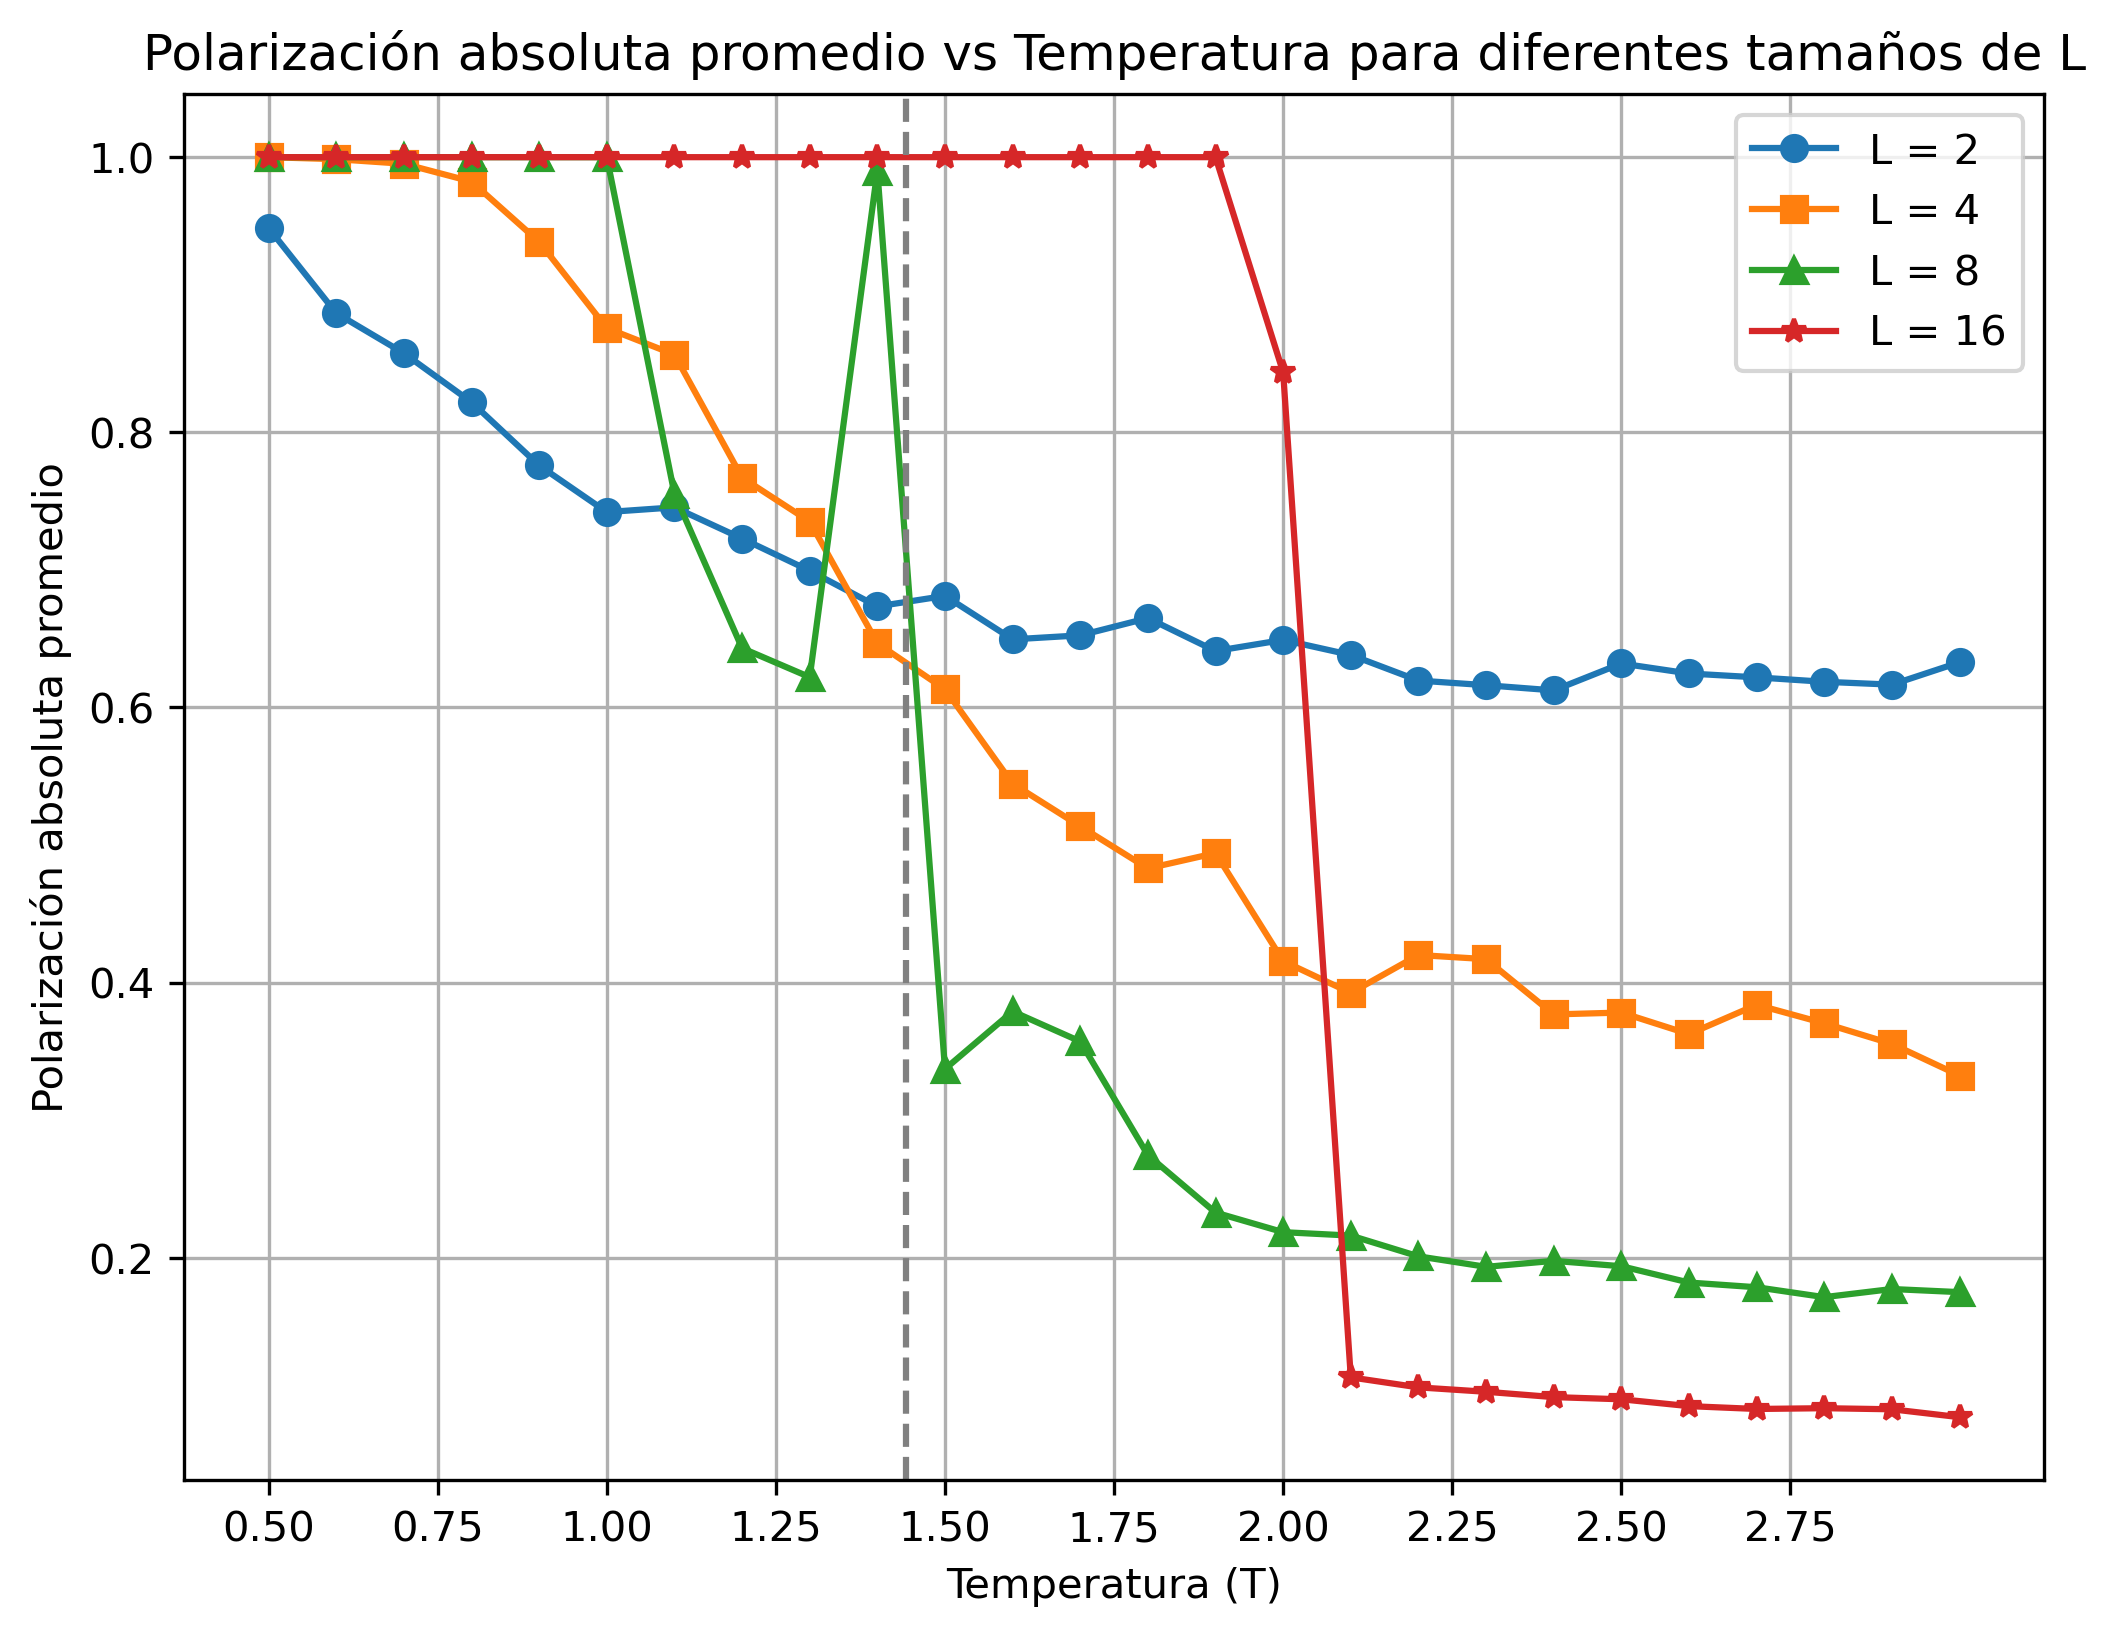

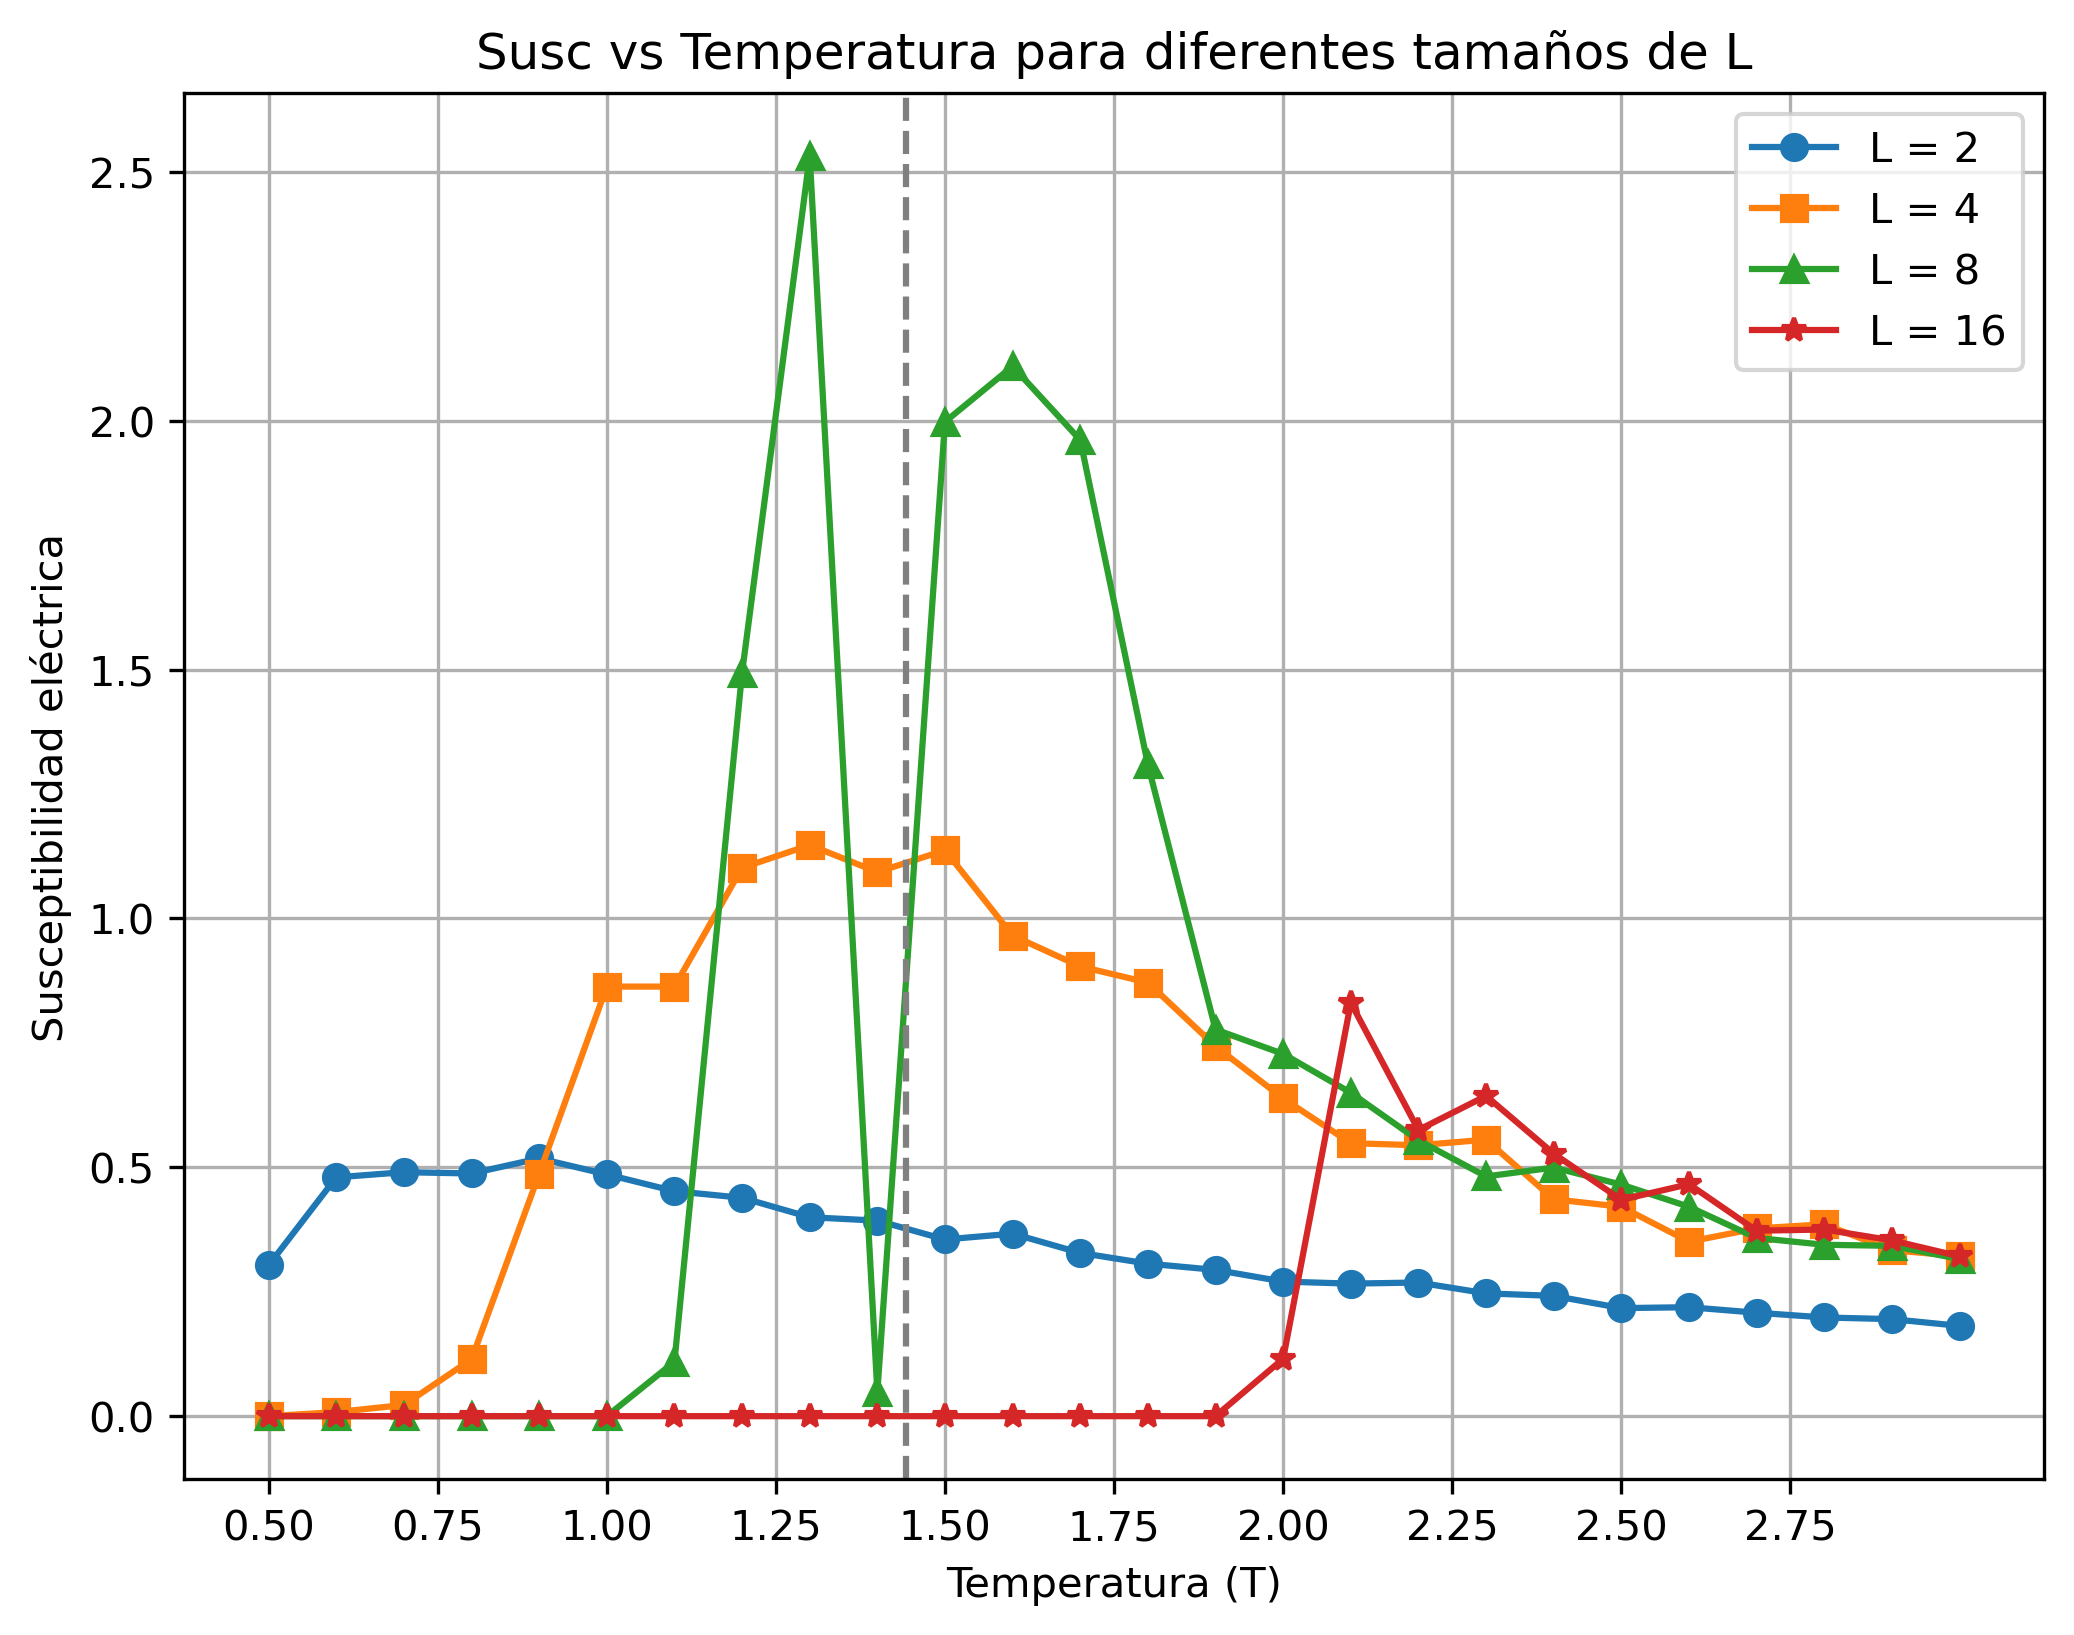

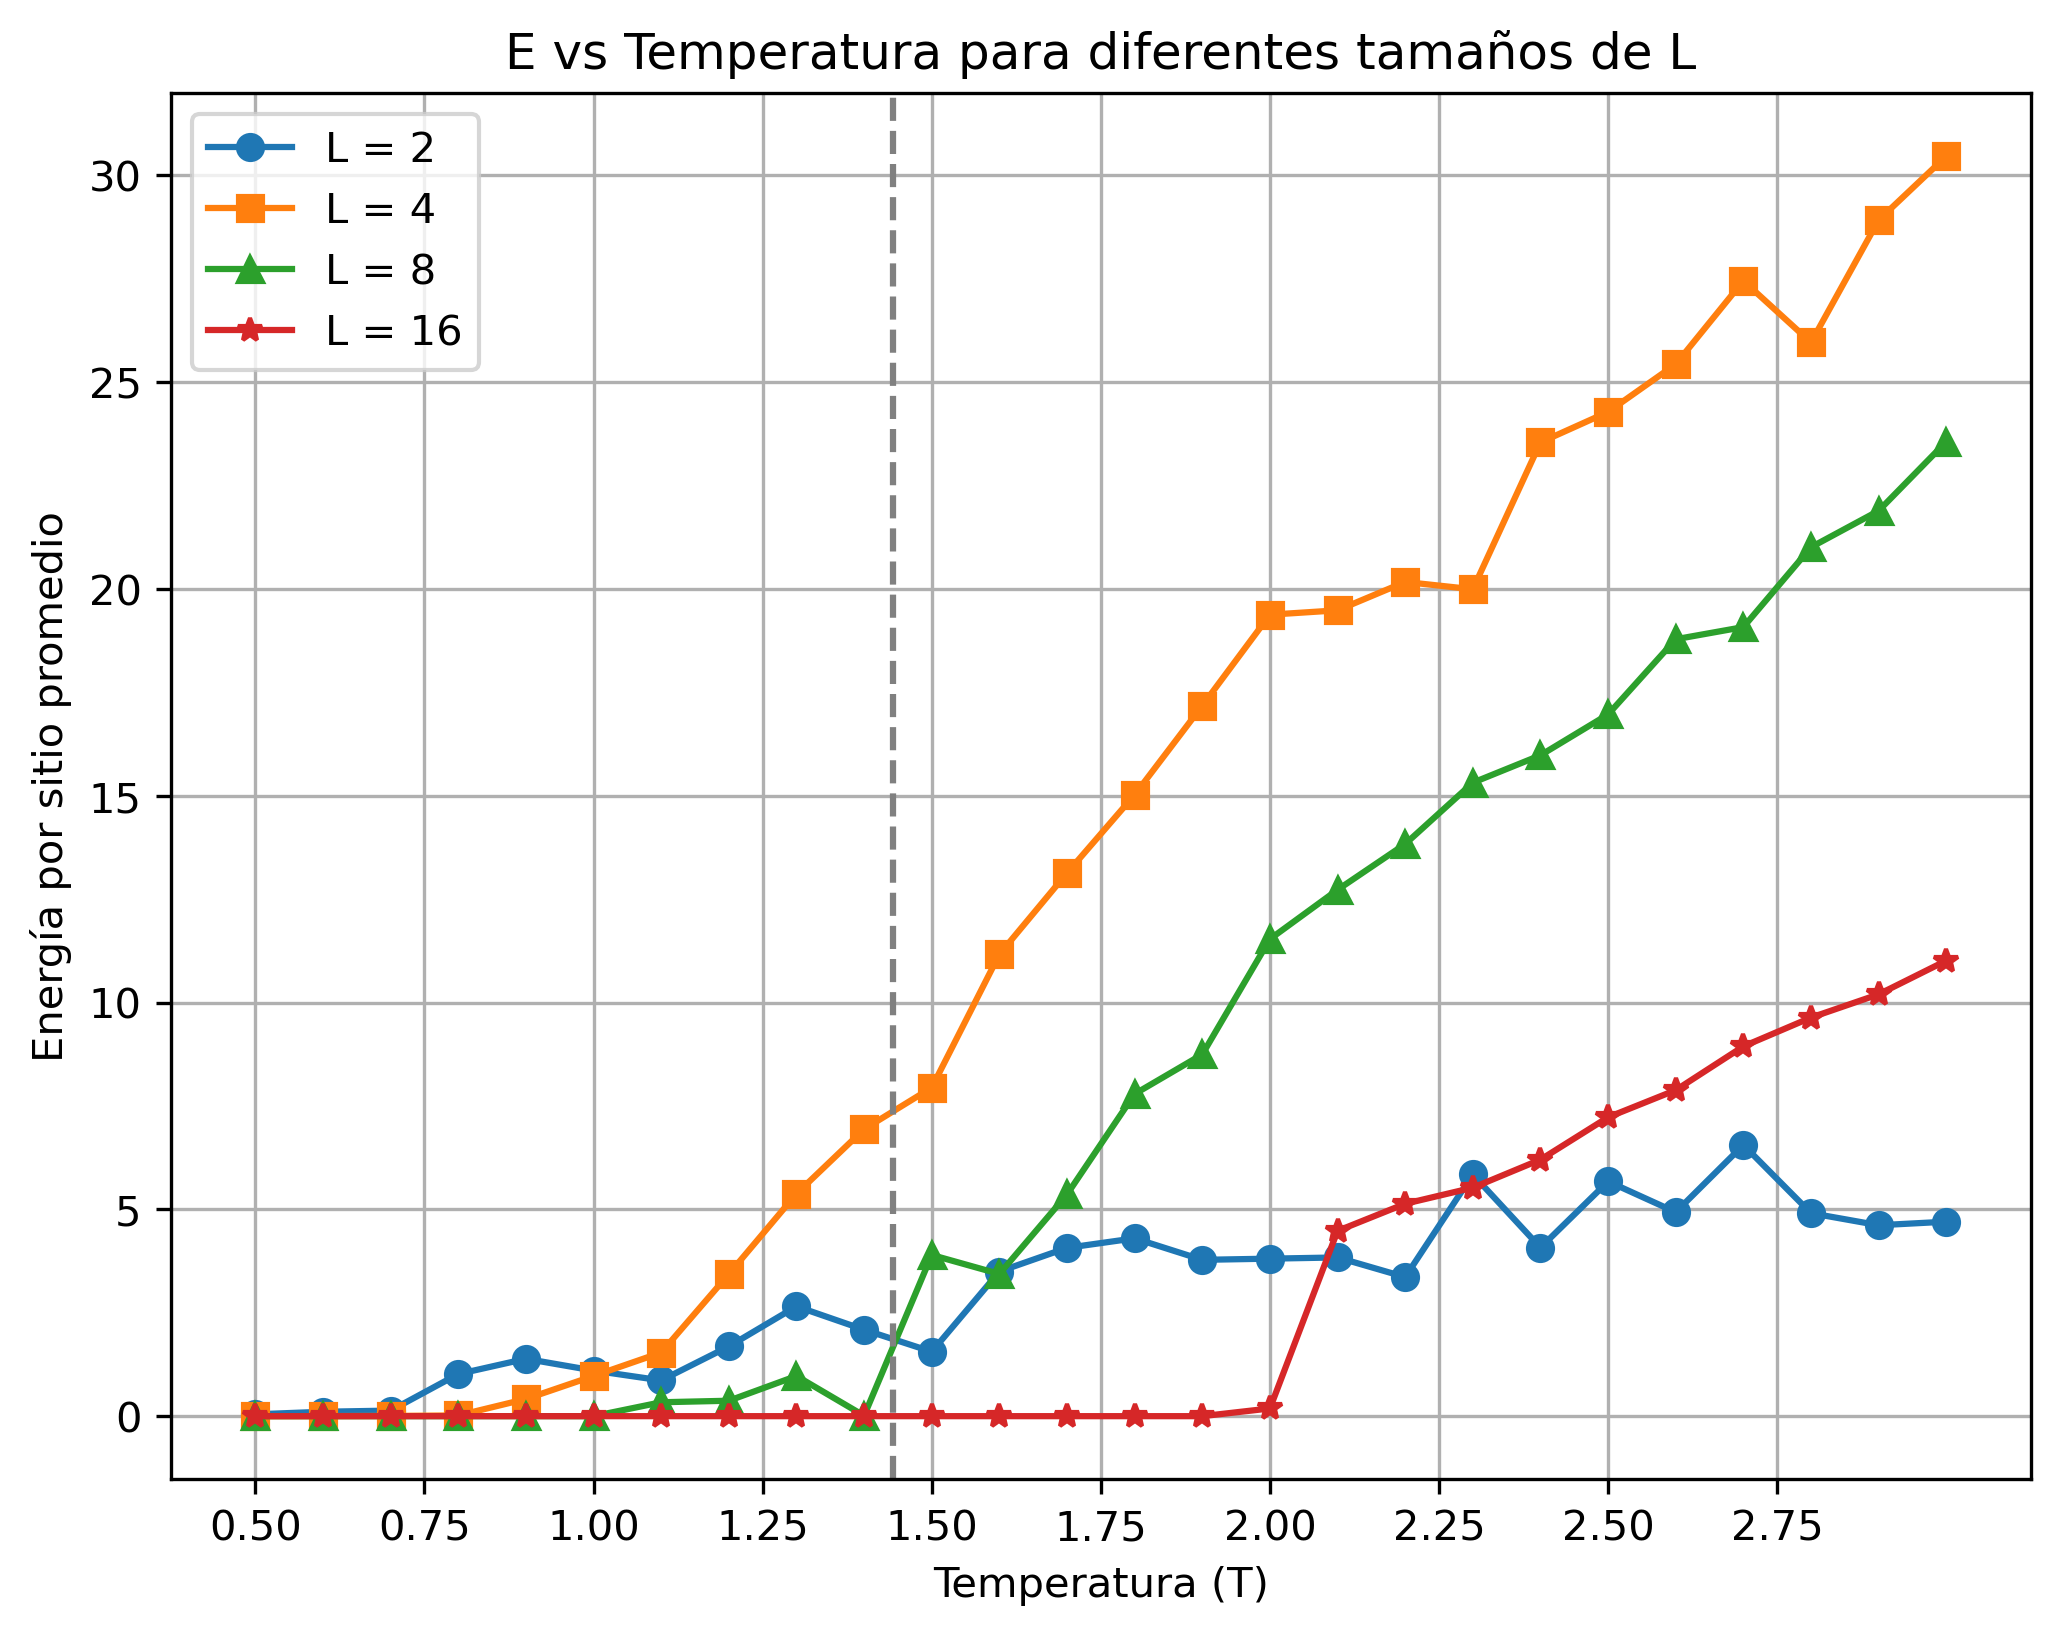

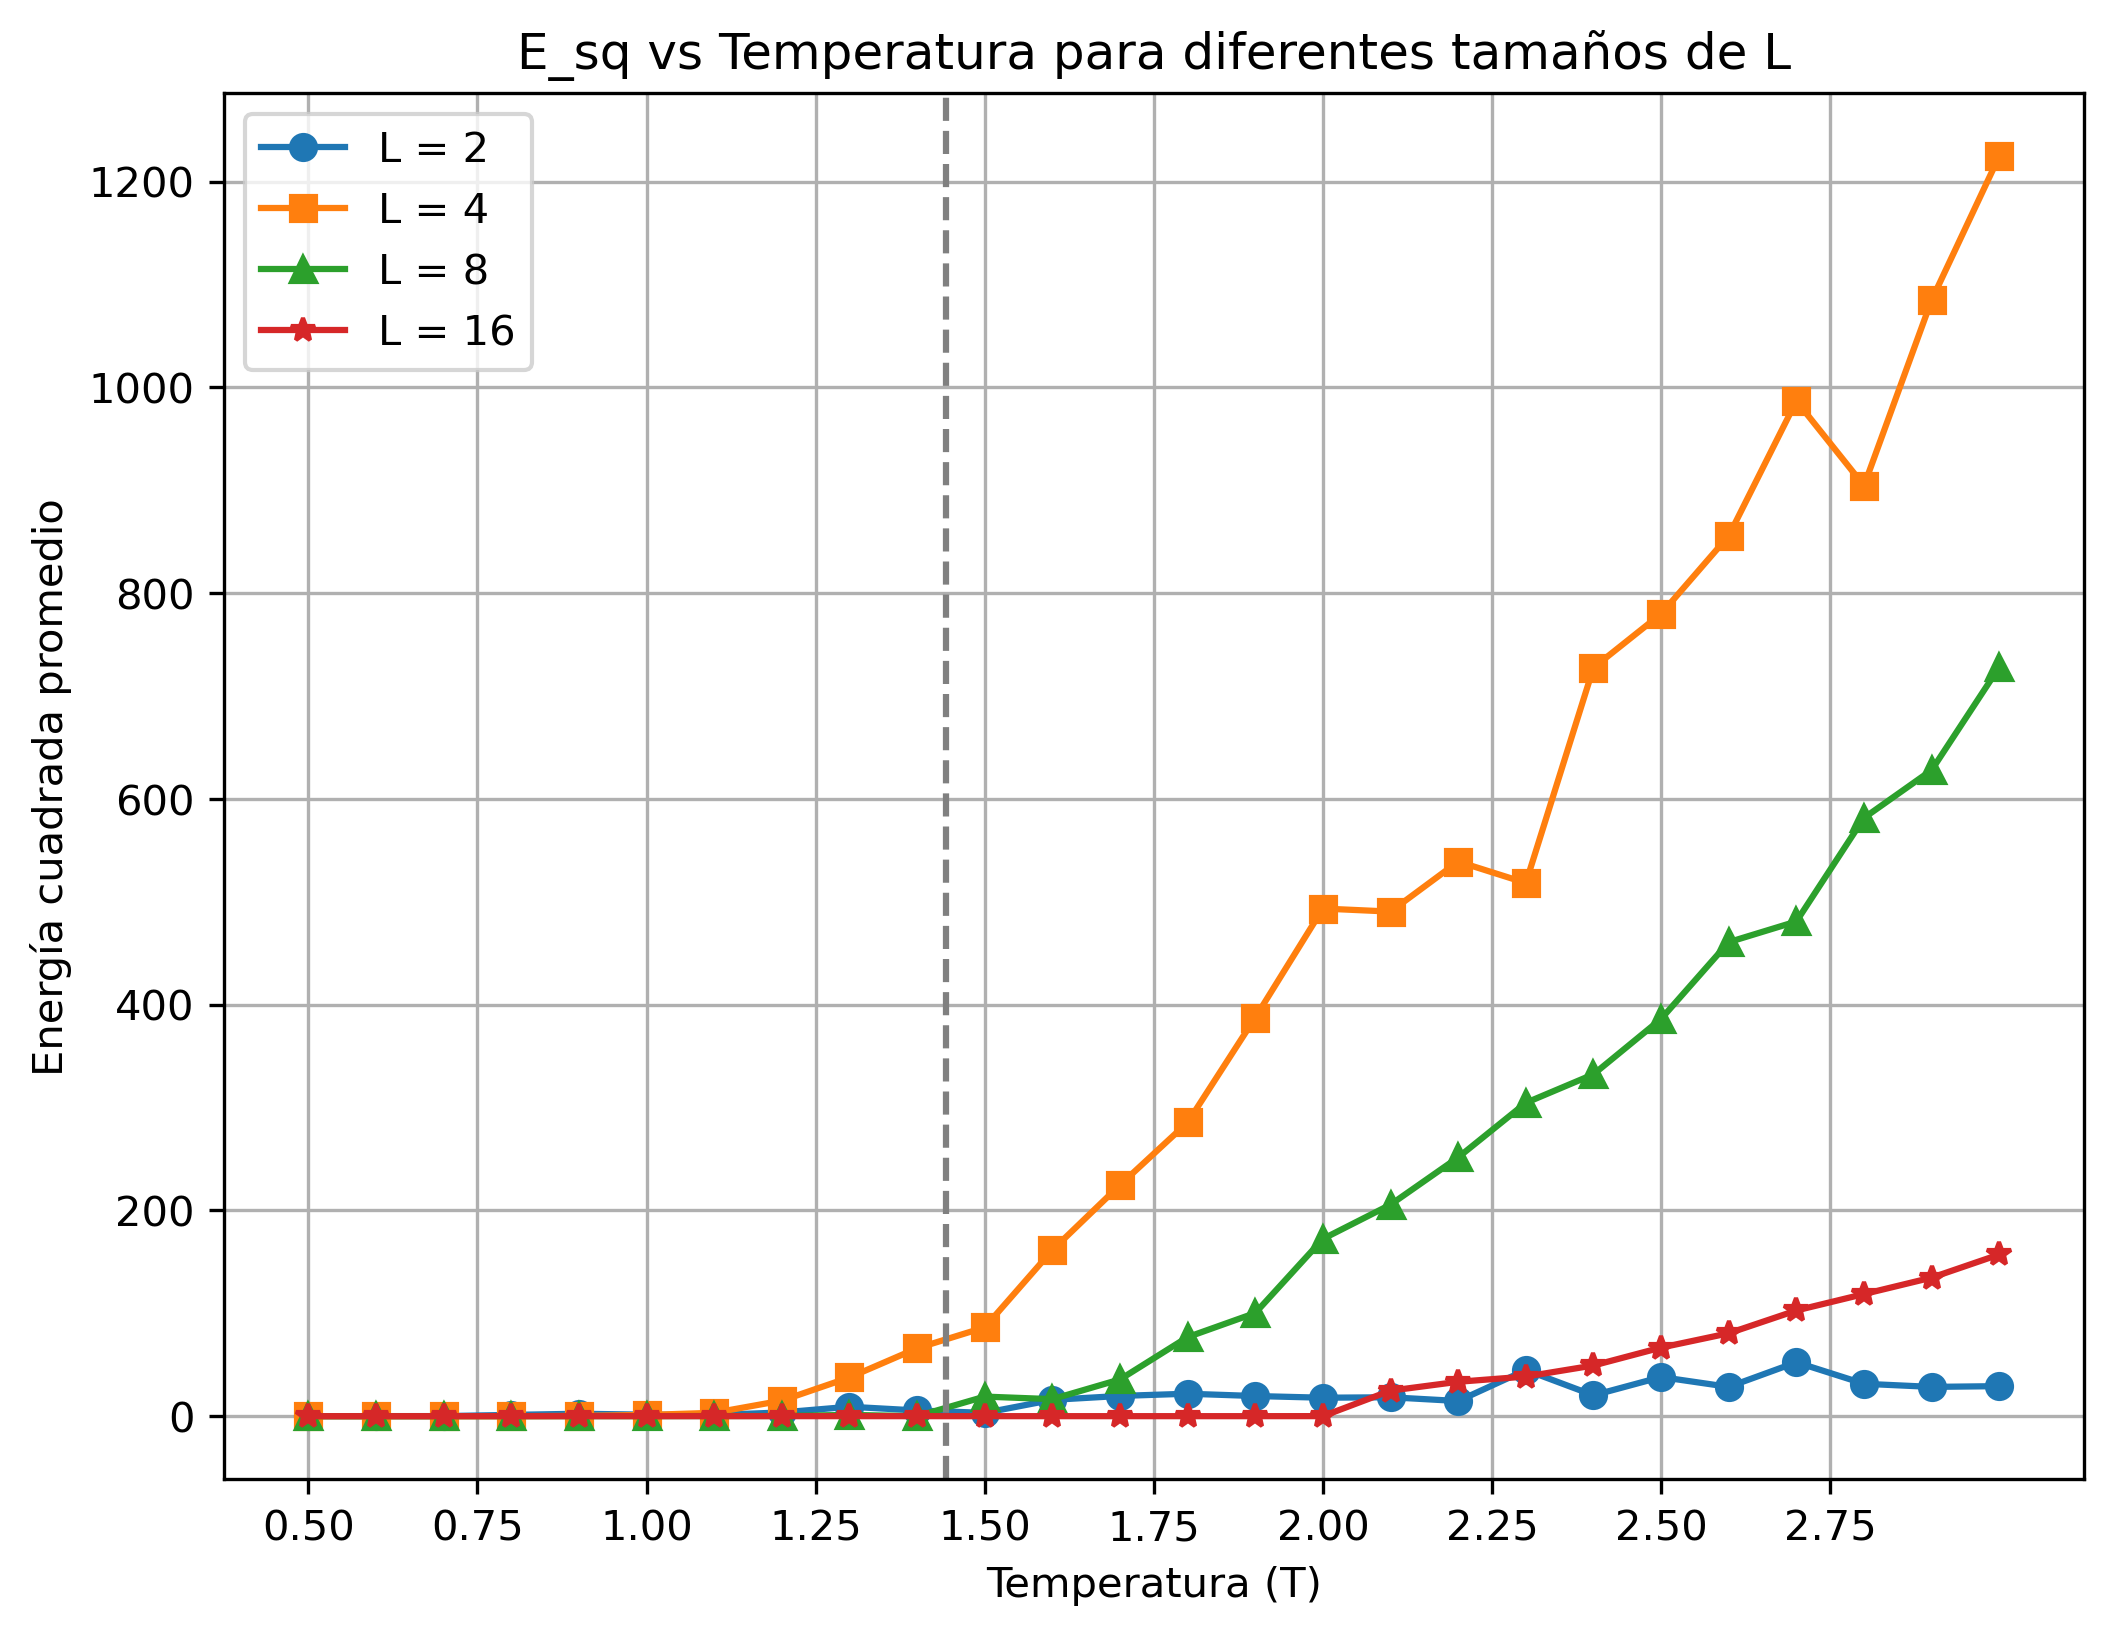

676730.3315031528


In [3]:
ini = time.time()
tamaño = [2, 4, 8, 16] #Definimos una lista con tamaños de L
marcadores = ['o', 's', '^', '*'] #Definimos los distintos marcadores de la gráfica 


fig1, ax1 = plt.subplots(figsize=(8, 6), dpi=300)  # Figura para Polarización
fig2, ax2 = plt.subplots(figsize=(8, 6), dpi=300)  # Figura para Susceptibilidad
fig3, ax3 = plt.subplots(figsize=(8, 6), dpi=300)  # Figura para Energia
fig4, ax4 = plt.subplots(figsize=(8, 6), dpi=300) #Figura para energia cuadrada


for lado, marcador in zip(tamaño, marcadores):
    print(f"Realizando la simulación de la lattice de tamaño {lado}...")
    simul = SixVertexModelArrows(L=lado, pasos_eq=5000, mc_pasos=1000)
    temp, etot_avg, etotsq_avg, mabstot_avg, sustot_avg = simul.experimentos_mc()
    ax1.plot(temp, mabstot_avg, label=f"L = {simul.L}", linestyle='-', marker=marcador)
    ax2.plot(temp, sustot_avg, label=f"L = {simul.L}", linestyle='-', marker=marcador)
    ax3.plot(temp, etot_avg, label=f"L = {simul.L}", linestyle='-', marker=marcador)
    ax4.plot(temp, etotsq_avg, label=f"L = {simul.L}", linestyle='-', marker=marcador)
    print(f"Simulación de tamaño {lado} terminada")

ax1.set_xlabel("Temperatura (T)")
ax1.set_ylabel("Polarización absoluta promedio")
ax1.set_title("Polarización absoluta promedio vs Temperatura para diferentes tamaños de L")
ax1.legend()
ax1.grid()
ax1.set_xticks(np.arange(min(temp), max(temp), step=(max(temp) - min(temp))/10))  # 10 divisiones en el eje X

ax2.set_xlabel("Temperatura (T)")
ax2.set_ylabel("Susceptibilidad eléctrica")
ax2.set_title("Susc vs Temperatura para diferentes tamaños de L")
ax2.legend()
ax2.grid()
ax2.set_xticks(np.arange(min(temp), max(temp), step=(max(temp) - min(temp))/10))  # 10 divisiones en el eje X

ax3.set_xlabel("Temperatura (T)")
ax3.set_ylabel("Energía por sitio promedio")
ax3.set_title("E vs Temperatura para diferentes tamaños de L")
ax3.legend()
ax3.grid()
ax3.set_xticks(np.arange(min(temp), max(temp), step=(max(temp) - min(temp))/10))  # 10 divisiones en el eje X

ax4.set_xlabel("Temperatura (T)")
ax4.set_ylabel("Energía cuadrada promedio")
ax4.set_title("E_sq vs Temperatura para diferentes tamaños de L")
ax4.legend()
ax4.grid()
ax4.set_xticks(np.arange(min(temp), max(temp), step=(max(temp) - min(temp))/10))  # 10 divisiones en el eje X

ax1.axvline(x = 1.443, color = 'grey', linestyle='--', label = 'T_c = 1.442...')
ax2.axvline(x = 1.443, color = 'grey', linestyle='--', label = 'T_c = 1.442...')
ax3.axvline(x = 1.443, color = 'grey', linestyle='--', label = 'T_c = 1.442...')
ax4.axvline(x = 1.443, color = 'grey', linestyle='--', label = 'T_c = 1.442...')

plt.show()
fin = time.time()
print(fin-ini)

Realizando la simulación de la lattice de tamaño 2...
Simulación de tamaño 2 terminada
Realizando la simulación de la lattice de tamaño 4...
Simulación de tamaño 4 terminada
Realizando la simulación de la lattice de tamaño 8...
Simulación de tamaño 8 terminada


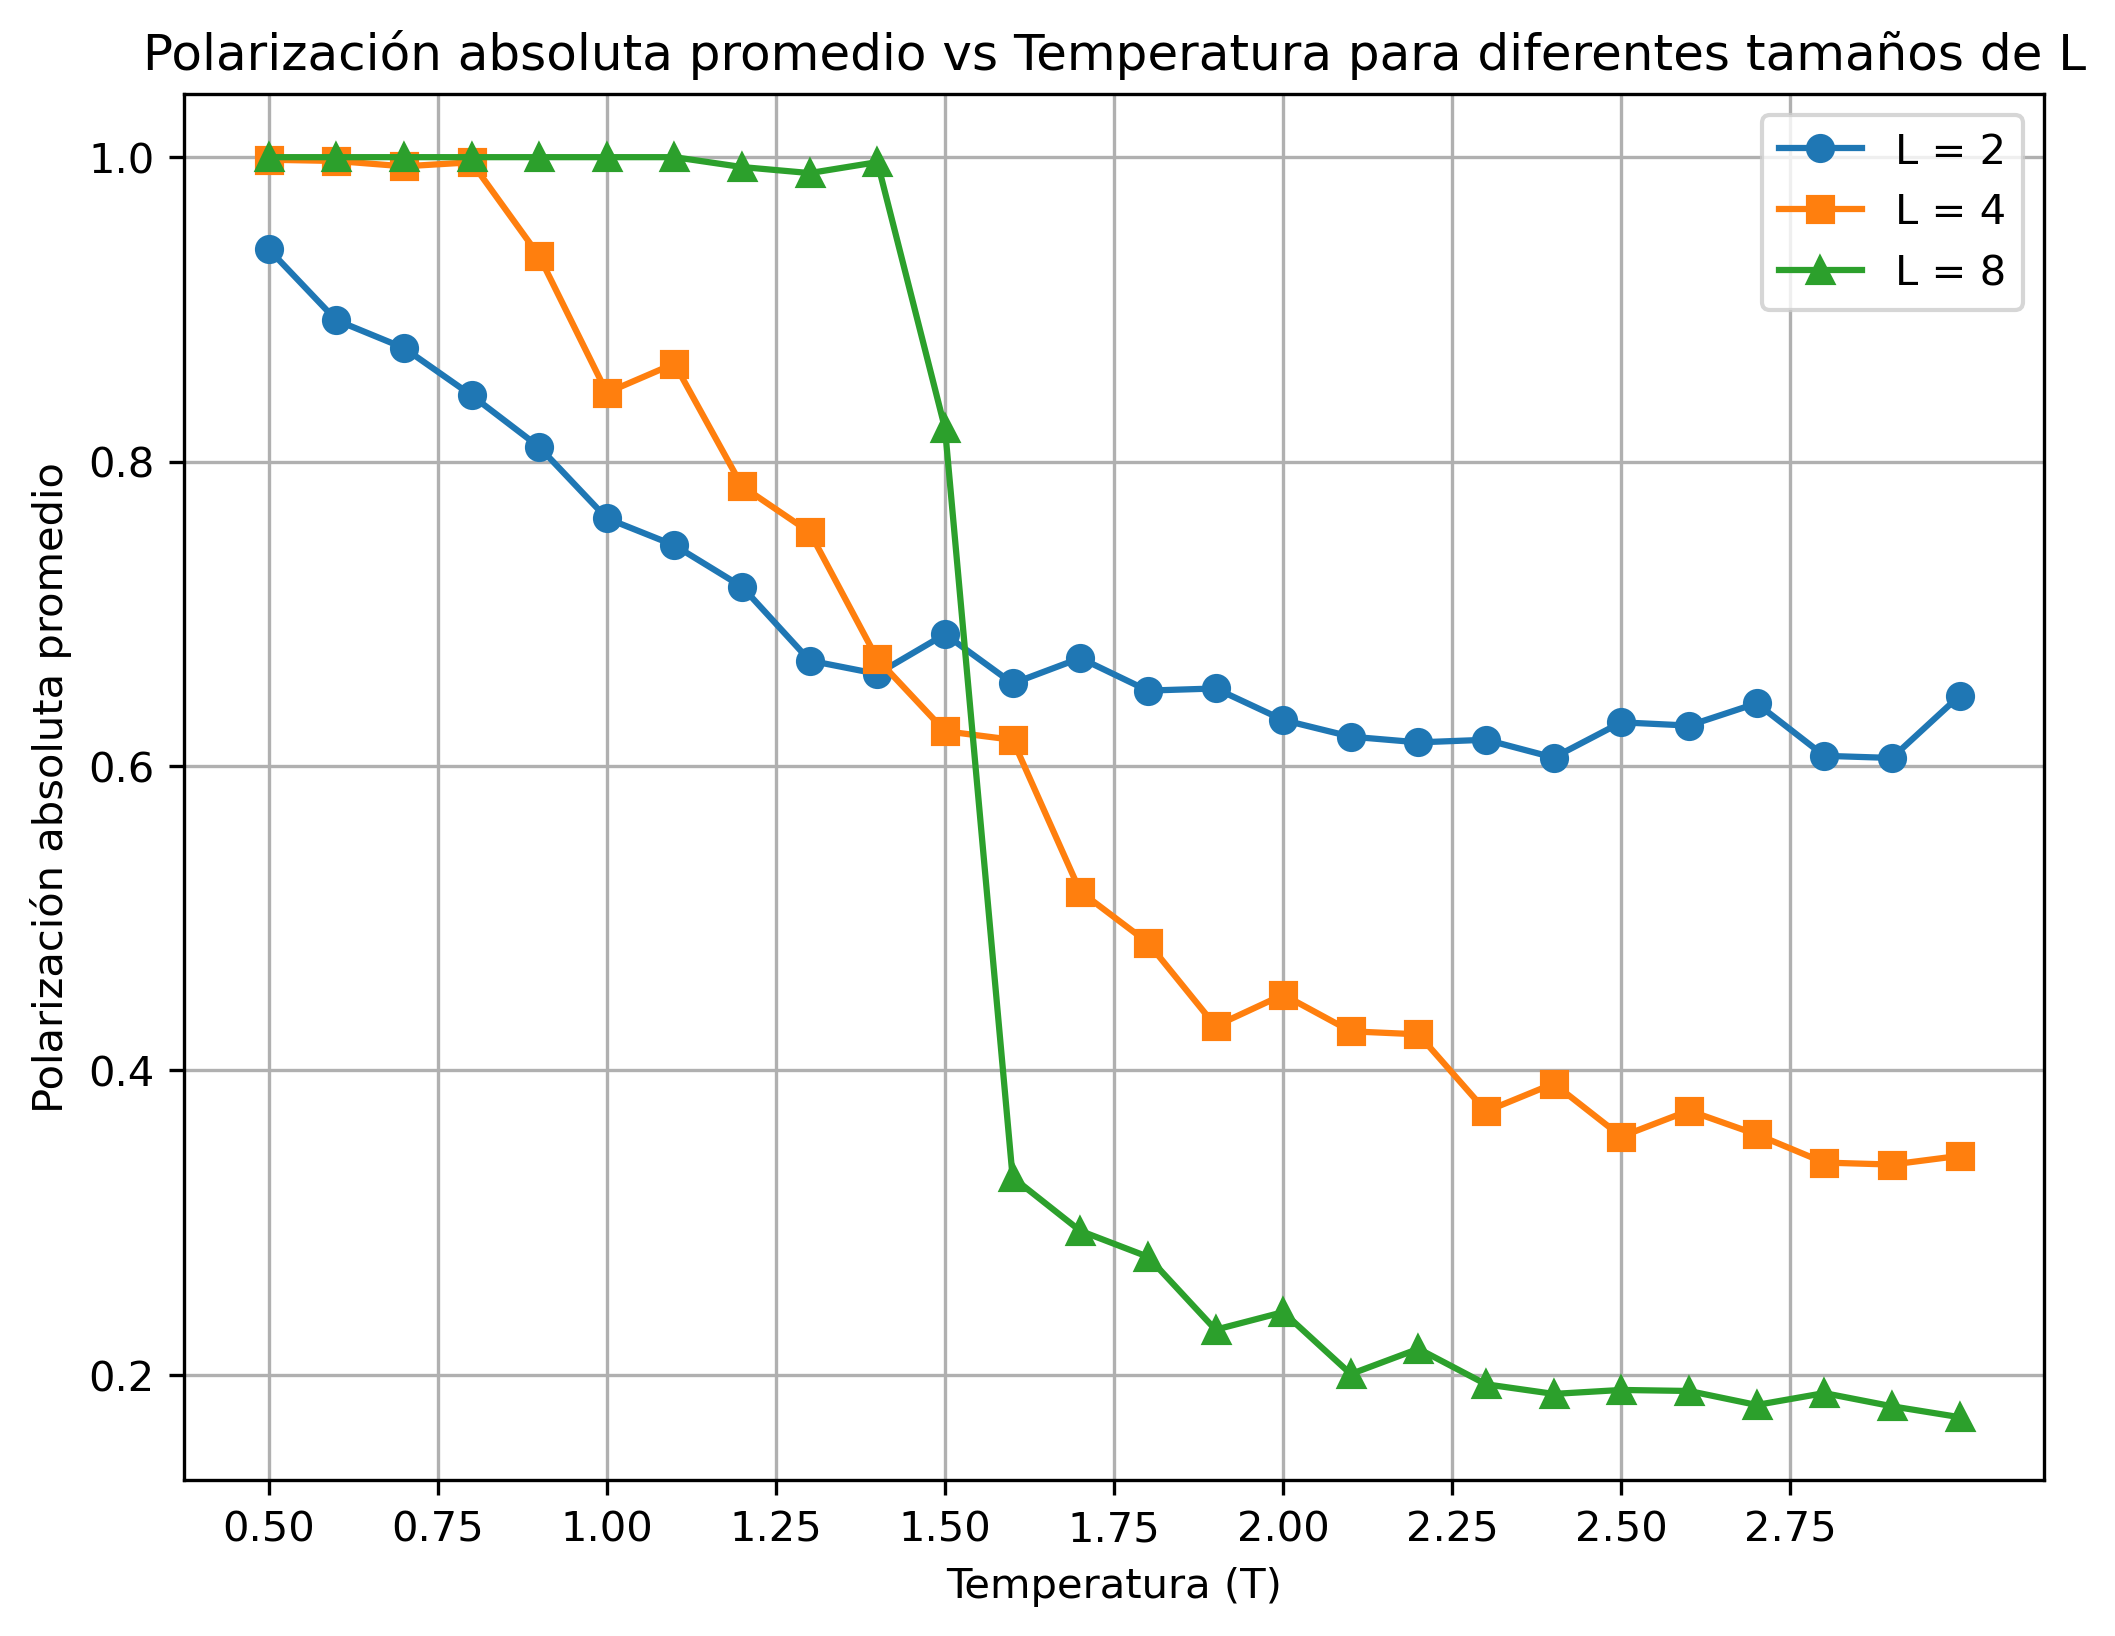

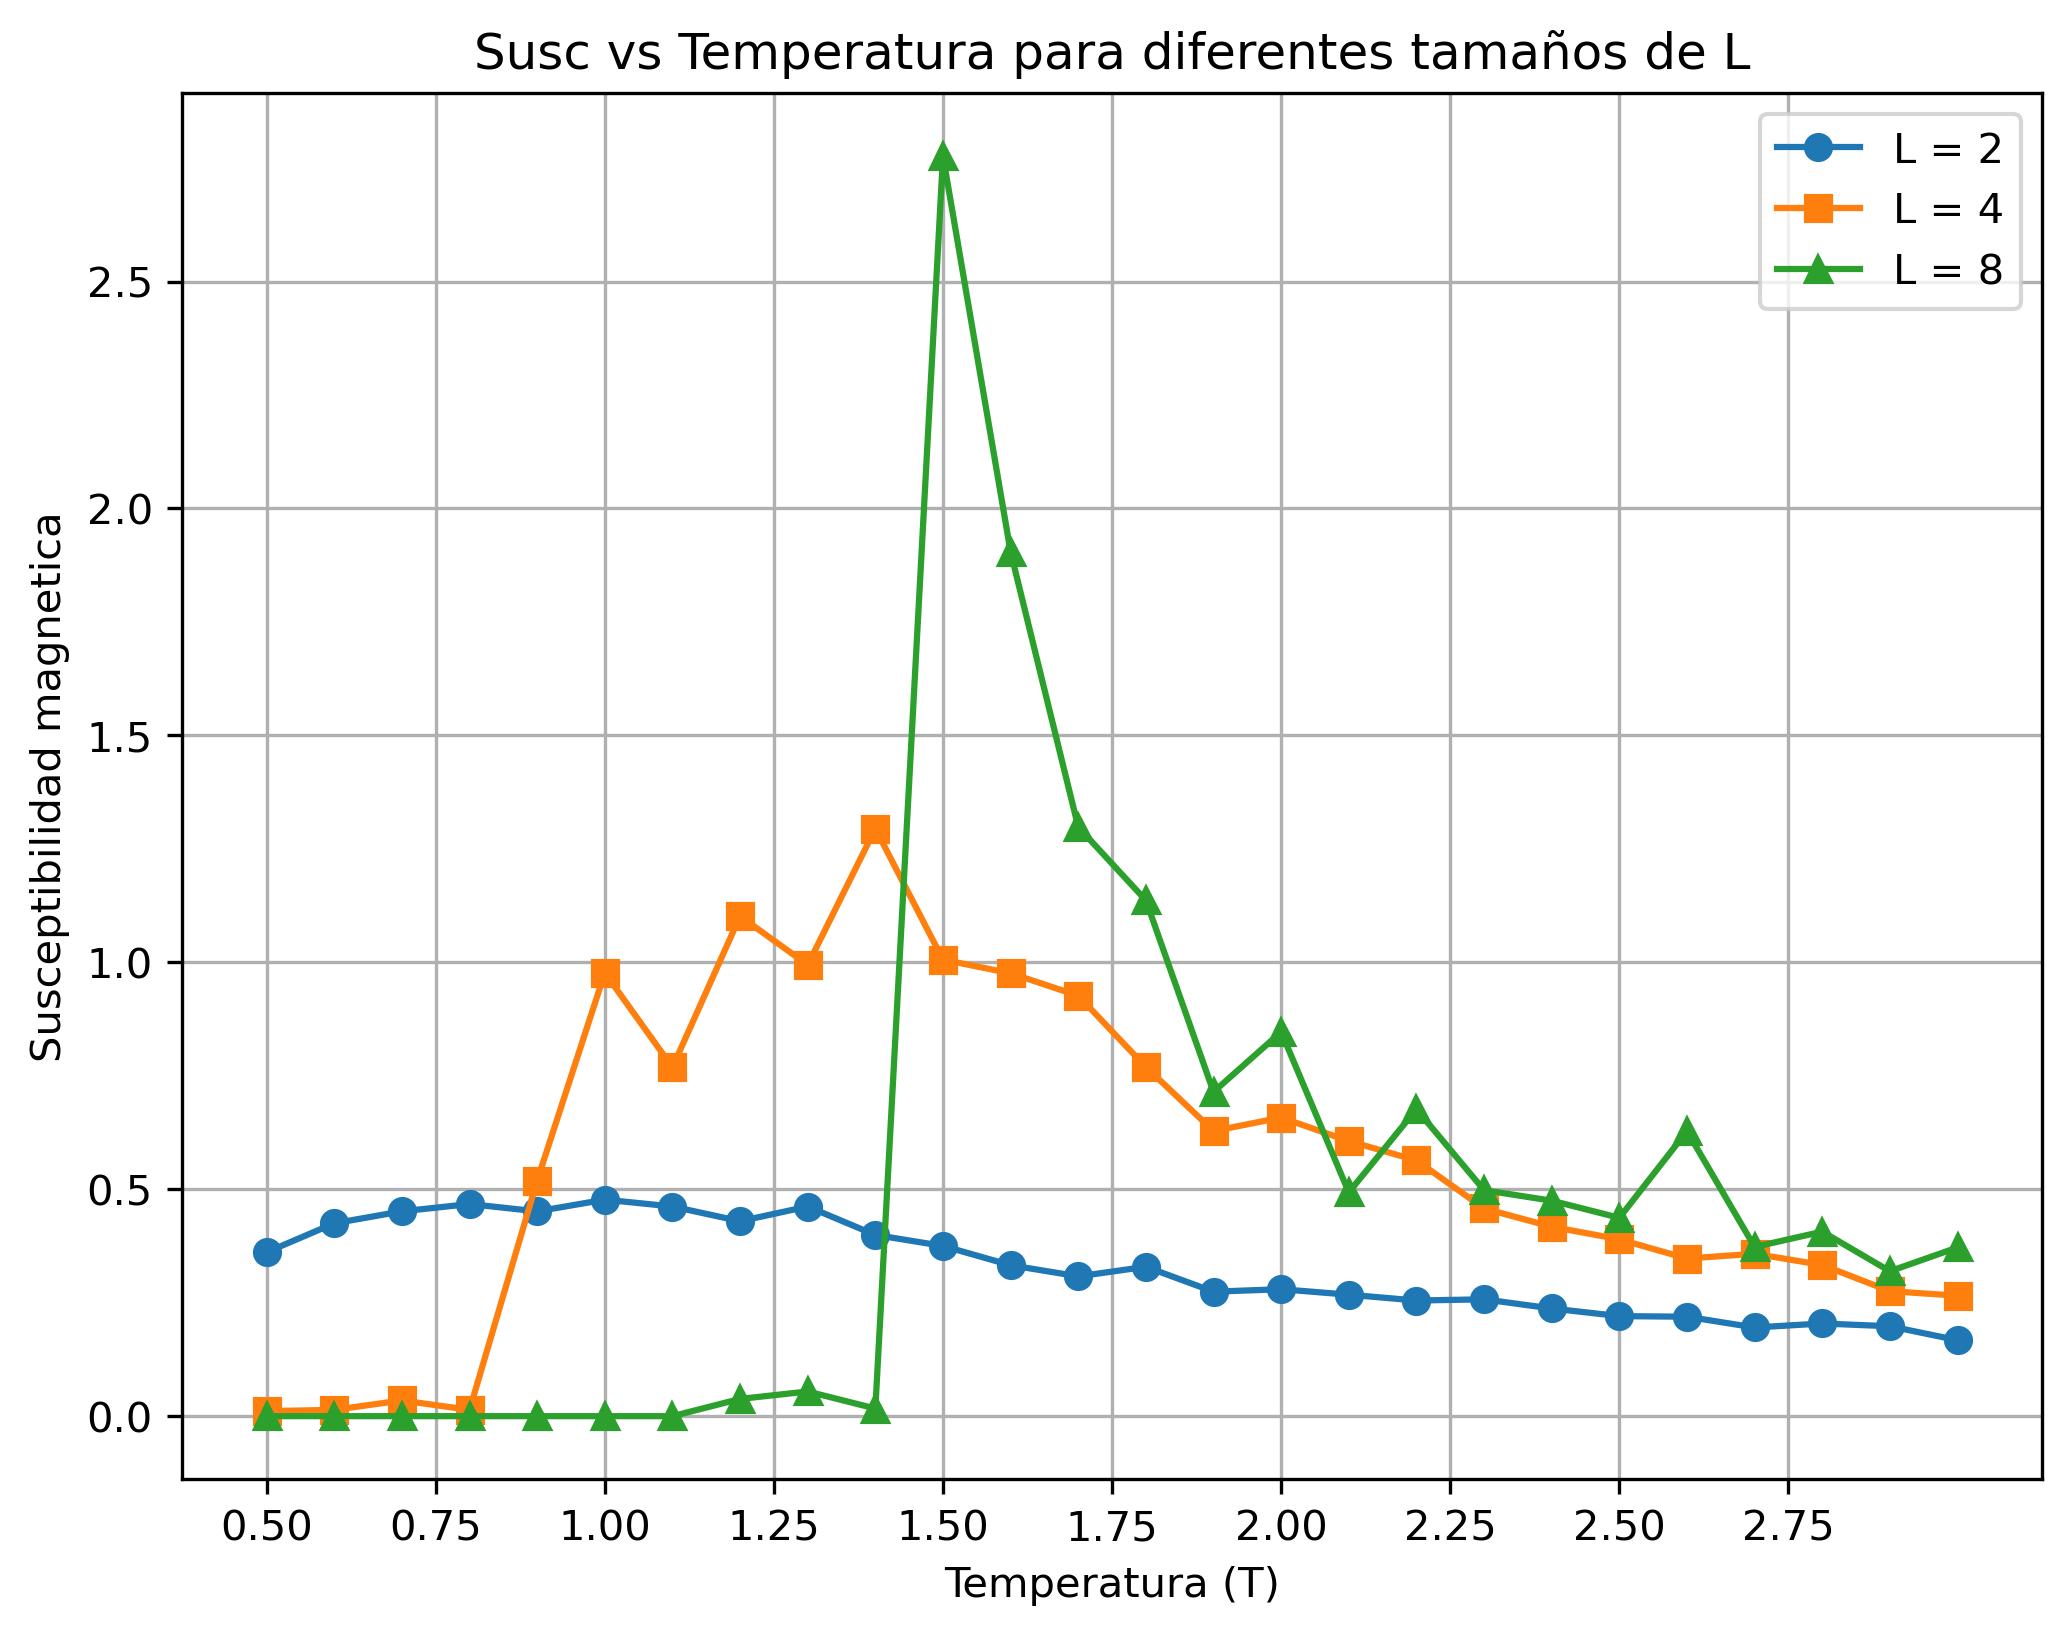

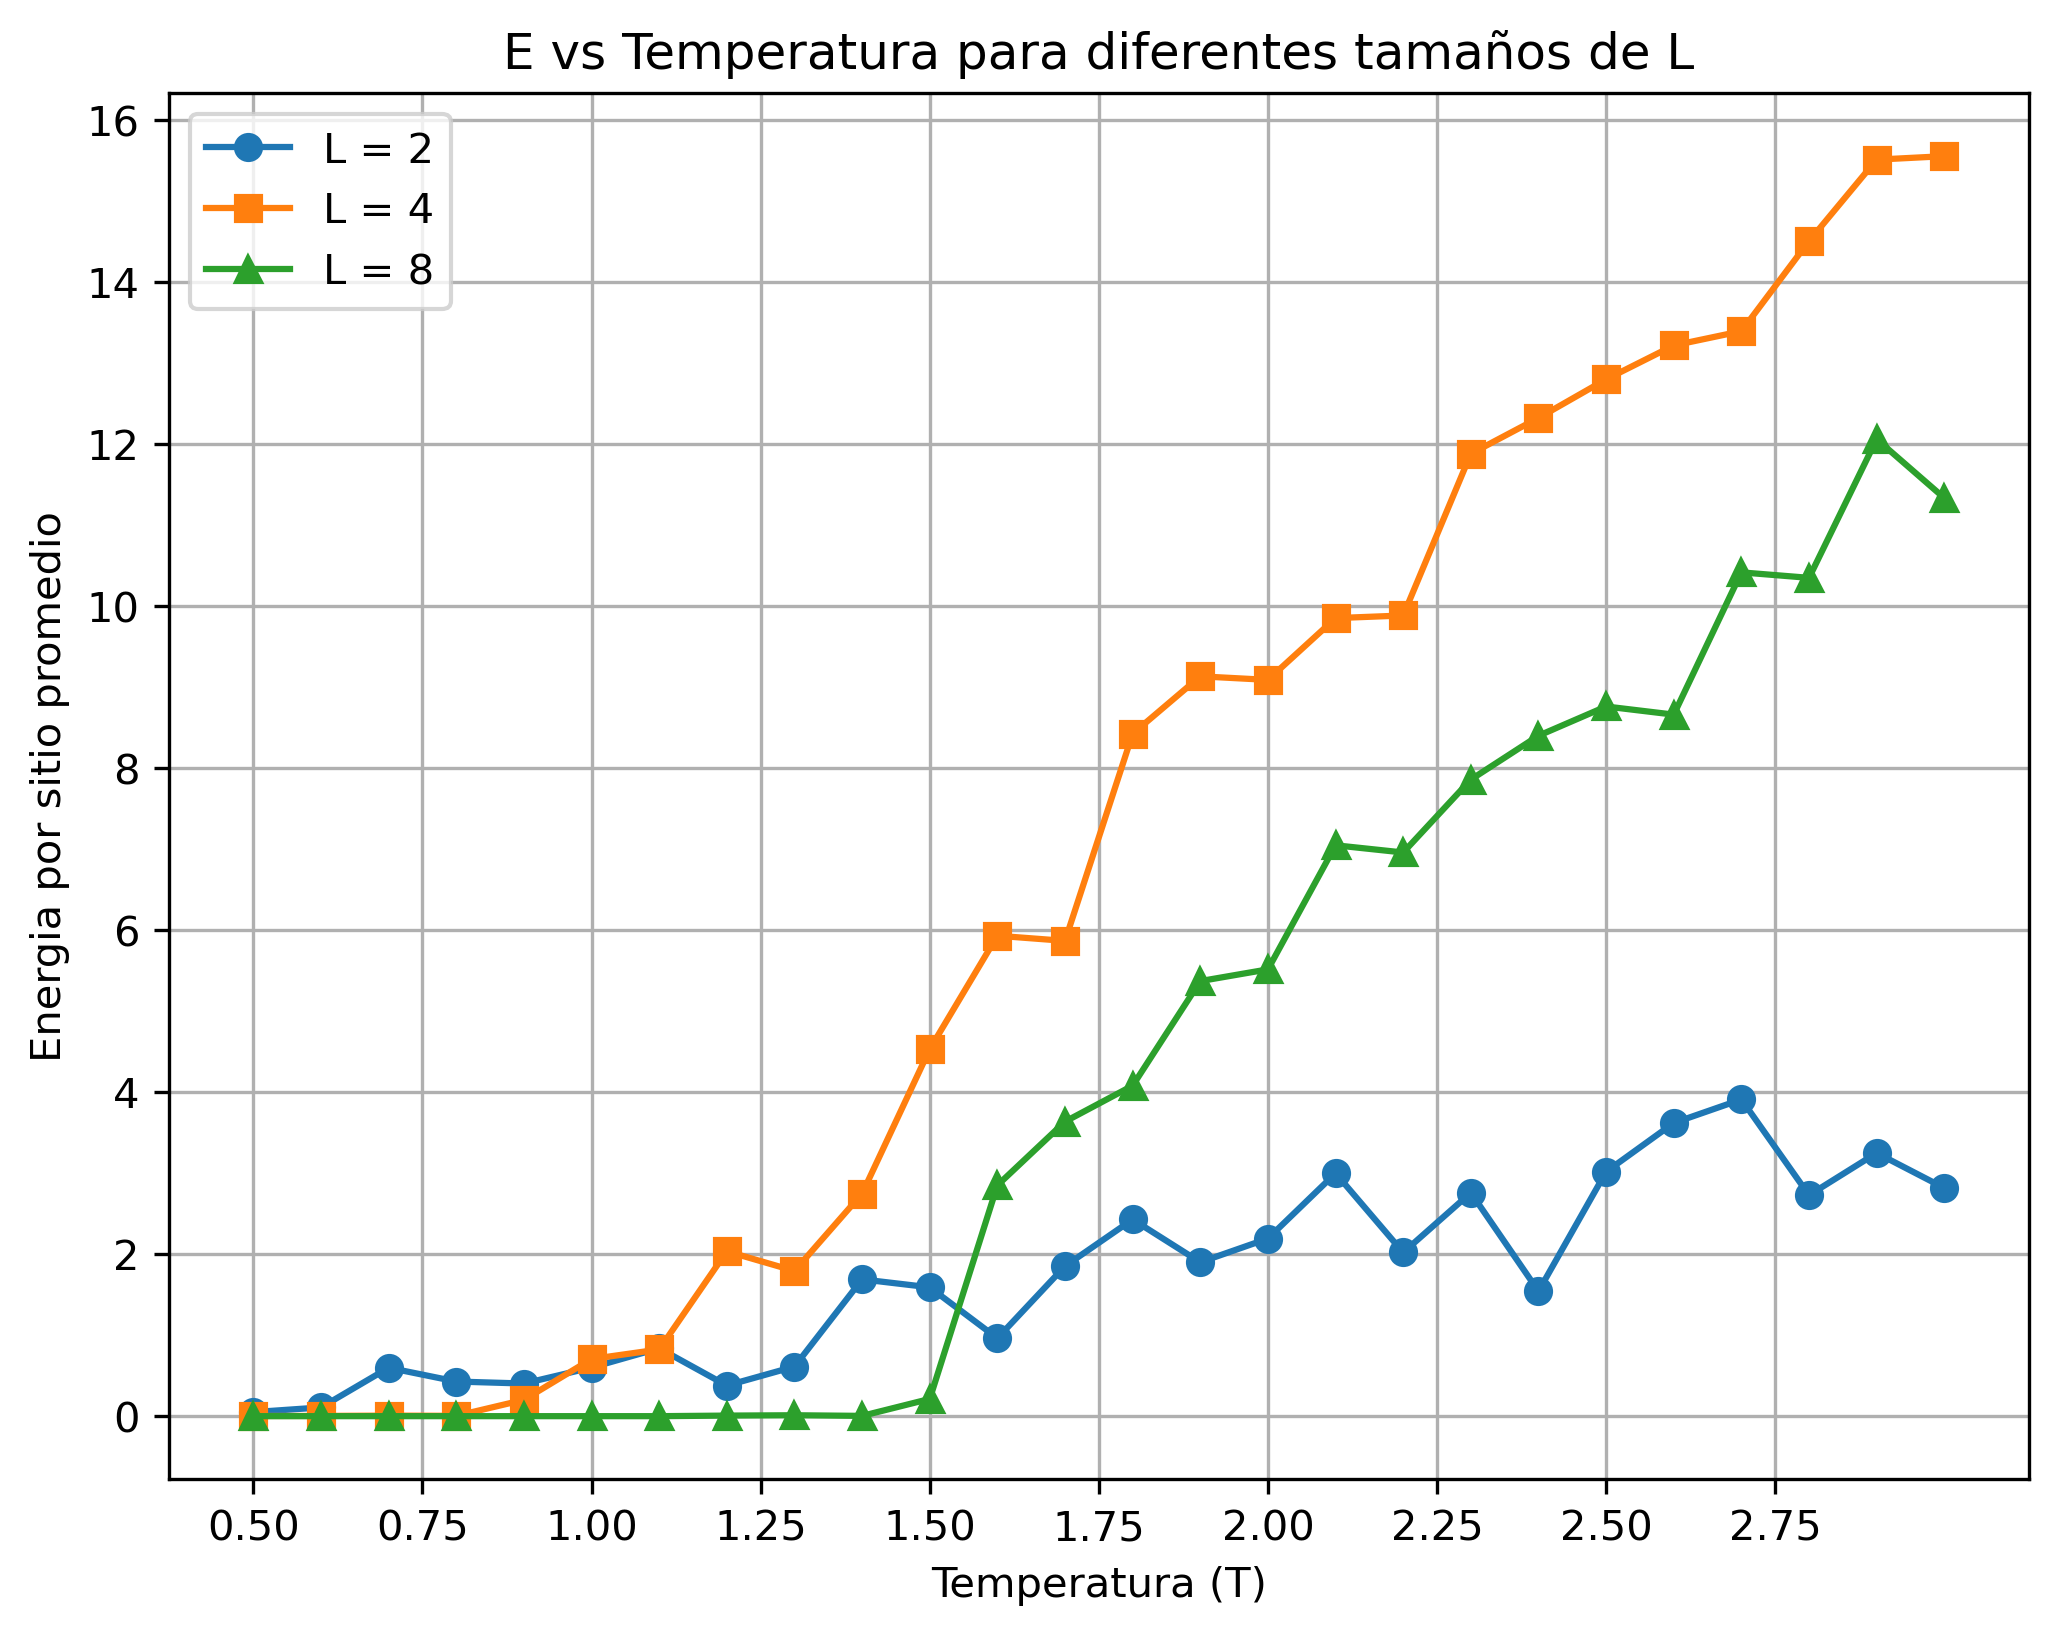

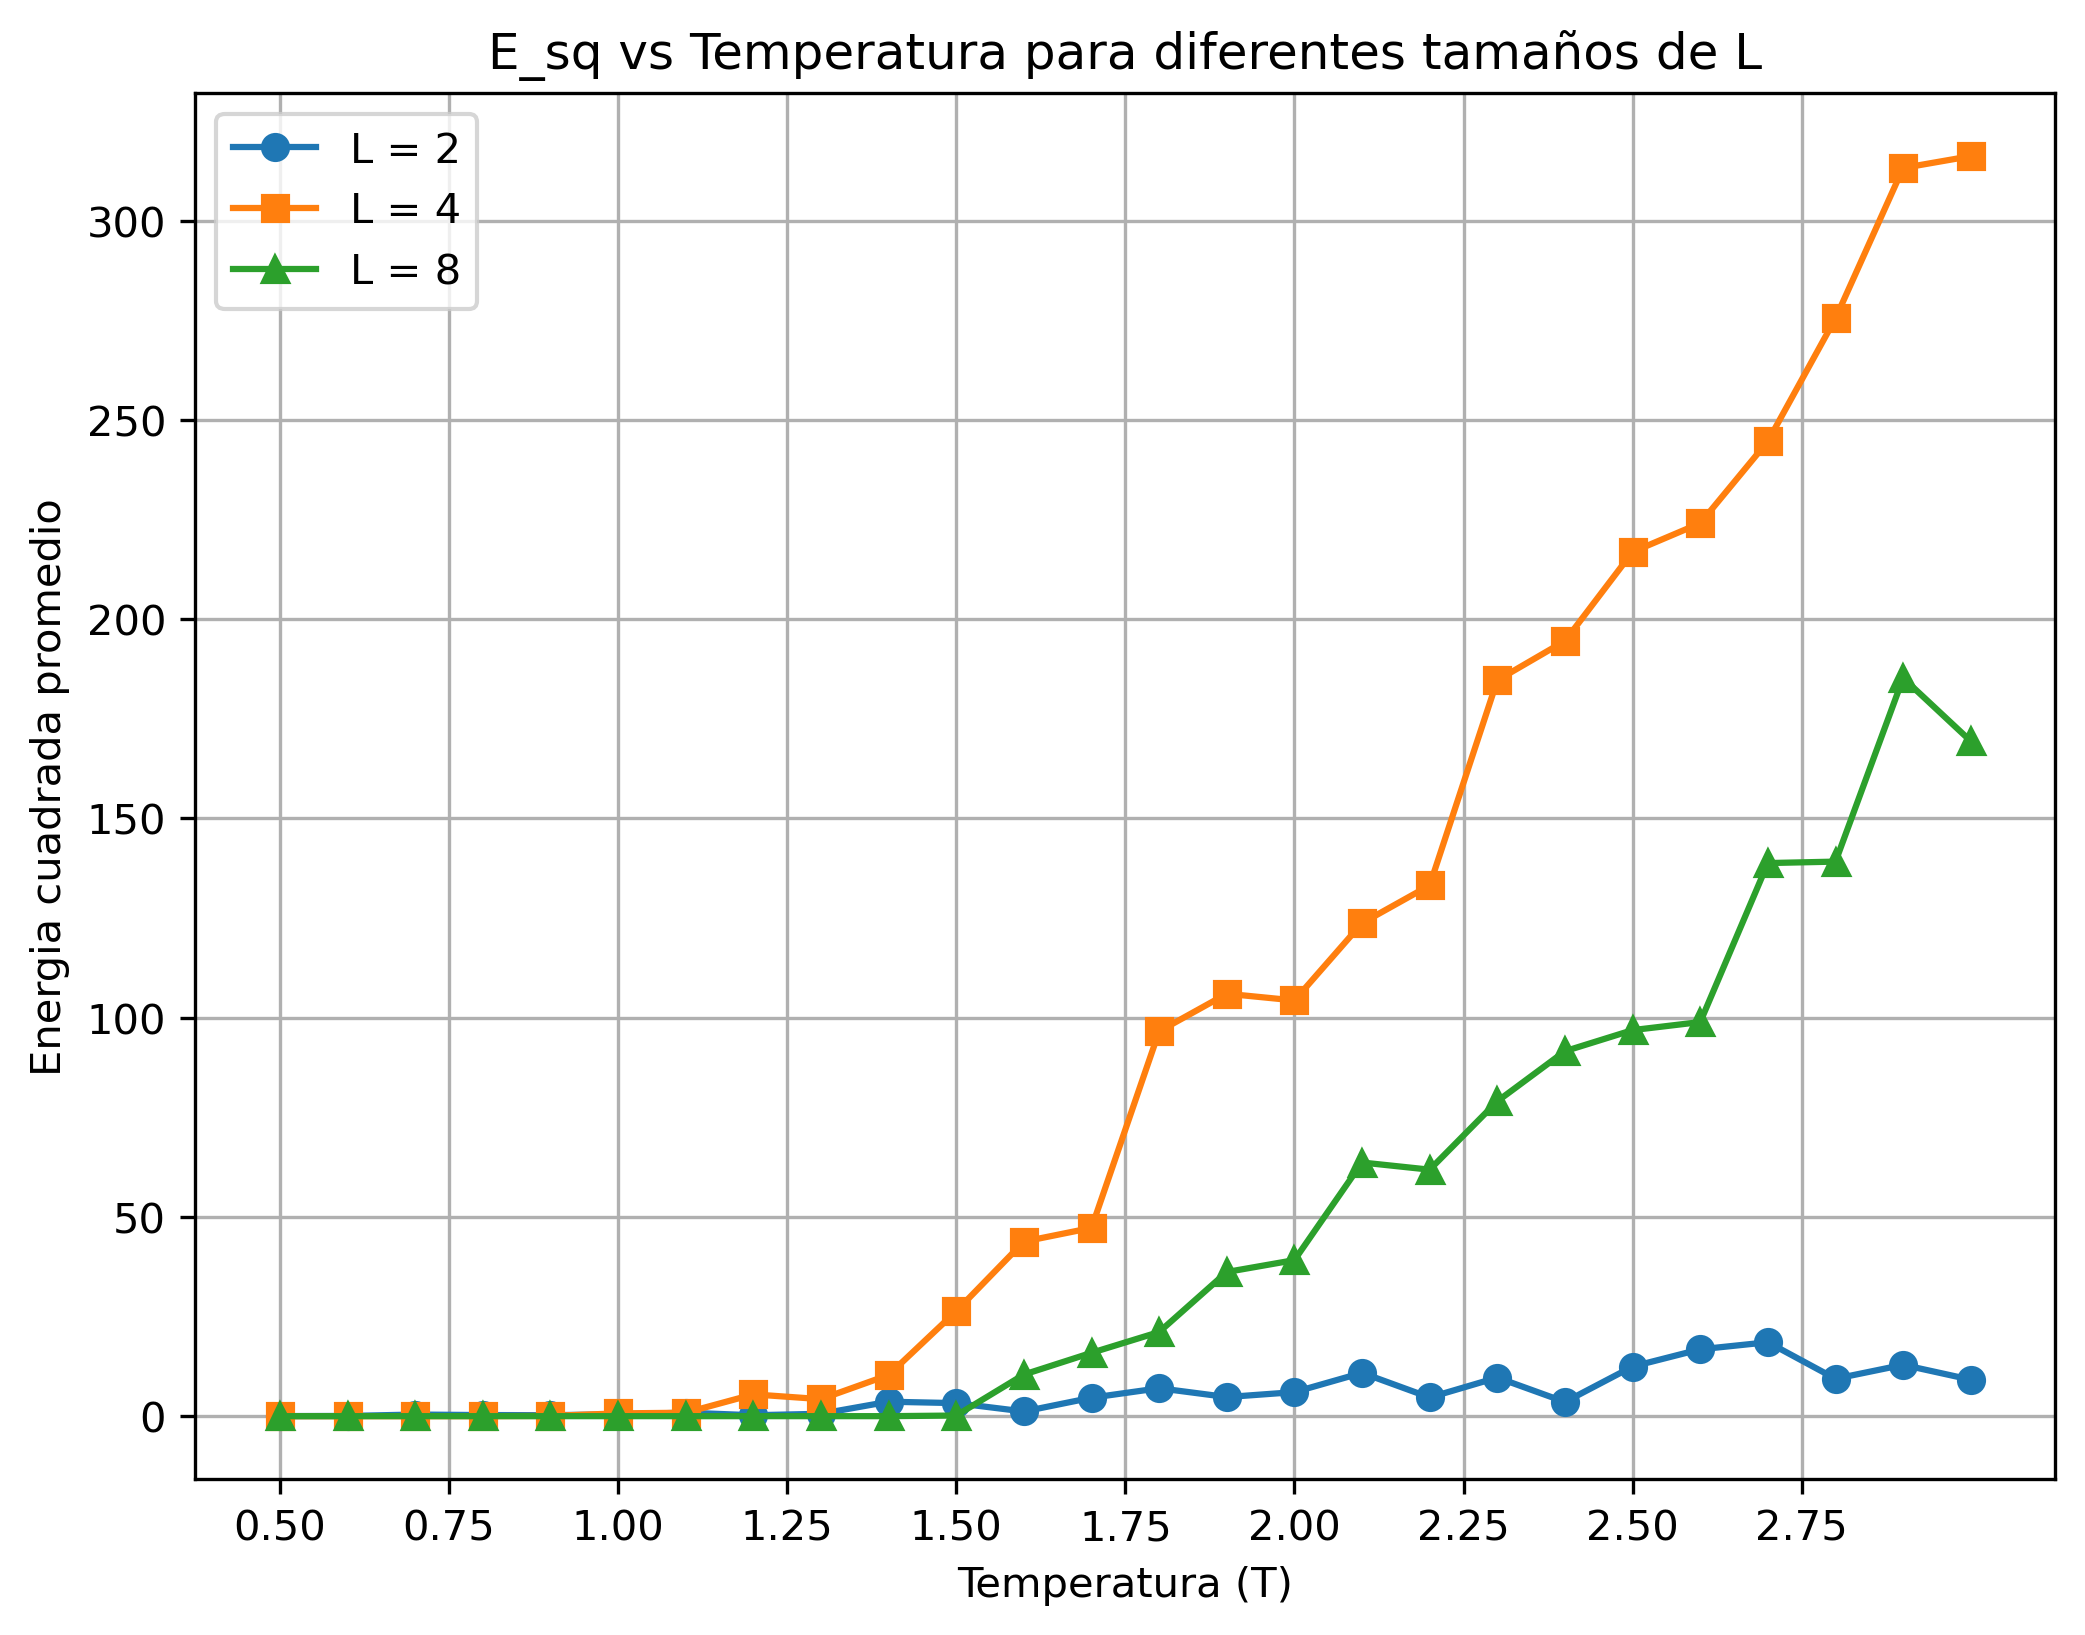

2689.2771649360657


In [12]:
ini = time.time()
tamaño = [2, 4, 8] #Definimos una lista con tamaños de L
marcadores = ['o', 's', '^'] #Definimos los distintos marcadores de la gráfica 


fig1, ax1 = plt.subplots(figsize=(8, 6), dpi=300)  # Figura para Polarización
fig2, ax2 = plt.subplots(figsize=(8, 6), dpi=300)  # Figura para Susceptibilidad
fig3, ax3 = plt.subplots(figsize=(8, 6), dpi=300)  # Figura para Energia
fig4, ax4 = plt.subplots(figsize=(8, 6), dpi=300) #Figura para energia cuadrada


for lado, marcador in zip(tamaño, marcadores):
    print(f"Realizando la simulación de la lattice de tamaño {lado}...")
    simul = SixVertexModelArrows(L=lado, pasos_eq=100, mc_pasos=500)
    temp, etot_avg, etotsq_avg, mabstot_avg, sustot_avg = simul.experimentos_mc()
    ax1.plot(temp, mabstot_avg, label=f"L = {simul.L}", linestyle='-', marker=marcador)
    ax2.plot(temp, sustot_avg, label=f"L = {simul.L}", linestyle='-', marker=marcador)
    ax3.plot(temp, etot_avg, label=f"L = {simul.L}", linestyle='-', marker=marcador)
    ax4.plot(temp, etotsq_avg, label=f"L = {simul.L}", linestyle='-', marker=marcador)
    print(f"Simulación de tamaño {lado} terminada")

ax1.set_xlabel("Temperatura (T)")
ax1.set_ylabel("Polarización absoluta promedio")
ax1.set_title("Polarización absoluta promedio vs Temperatura para diferentes tamaños de L")
ax1.legend()
ax1.grid()
ax1.set_xticks(np.arange(min(temp), max(temp), step=(max(temp) - min(temp))/10))  # 10 divisiones en el eje X

ax2.set_xlabel("Temperatura (T)")
ax2.set_ylabel("Susceptibilidad magnetica")
ax2.set_title("Susc vs Temperatura para diferentes tamaños de L")
ax2.legend()
ax2.grid()
ax2.set_xticks(np.arange(min(temp), max(temp), step=(max(temp) - min(temp))/10))  # 10 divisiones en el eje X

ax3.set_xlabel("Temperatura (T)")
ax3.set_ylabel("Energia por sitio promedio")
ax3.set_title("E vs Temperatura para diferentes tamaños de L")
ax3.legend()
ax3.grid()
ax3.set_xticks(np.arange(min(temp), max(temp), step=(max(temp) - min(temp))/10))  # 10 divisiones en el eje X

ax4.set_xlabel("Temperatura (T)")
ax4.set_ylabel("Energia cuadrada promedio")
ax4.set_title("E_sq vs Temperatura para diferentes tamaños de L")
ax4.legend()
ax4.grid()
ax4.set_xticks(np.arange(min(temp), max(temp), step=(max(temp) - min(temp))/10))  # 10 divisiones en el eje X


plt.show()
fin = time.time()
print(fin-ini)

Realizando la simulación de la lattice de tamaño 2...
Simulación de tamaño 2 terminada
Realizando la simulación de la lattice de tamaño 4...
Simulación de tamaño 4 terminada
Realizando la simulación de la lattice de tamaño 8...
Simulación de tamaño 8 terminada


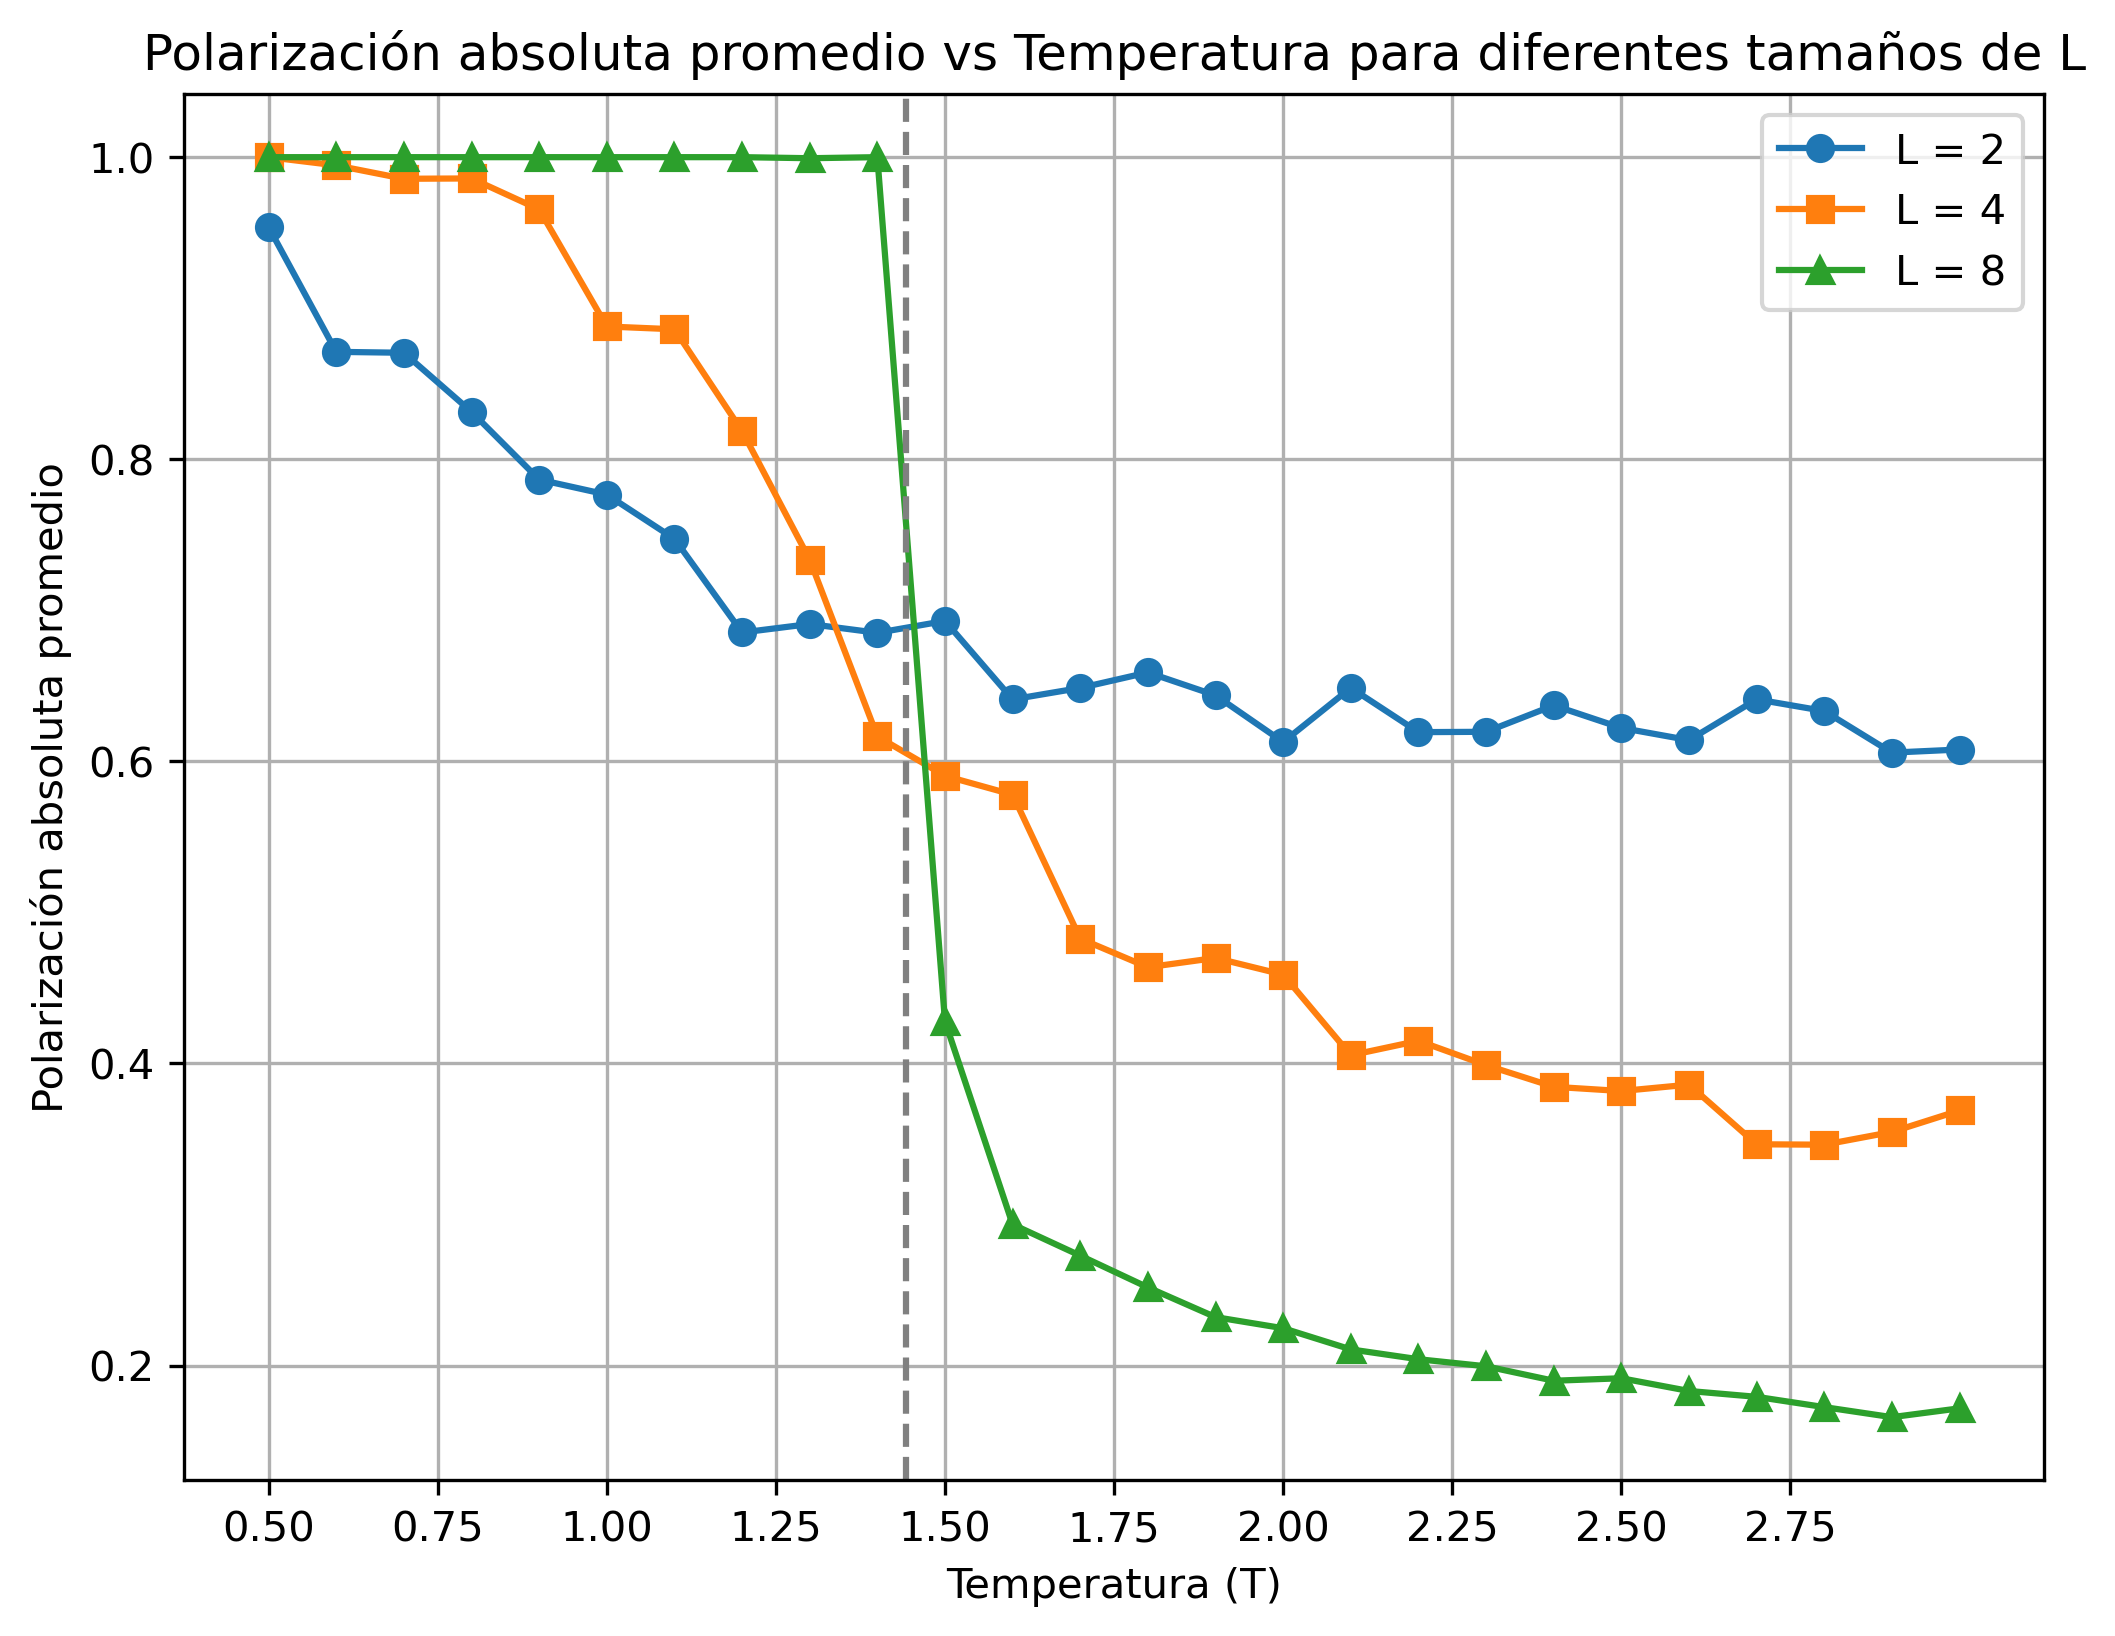

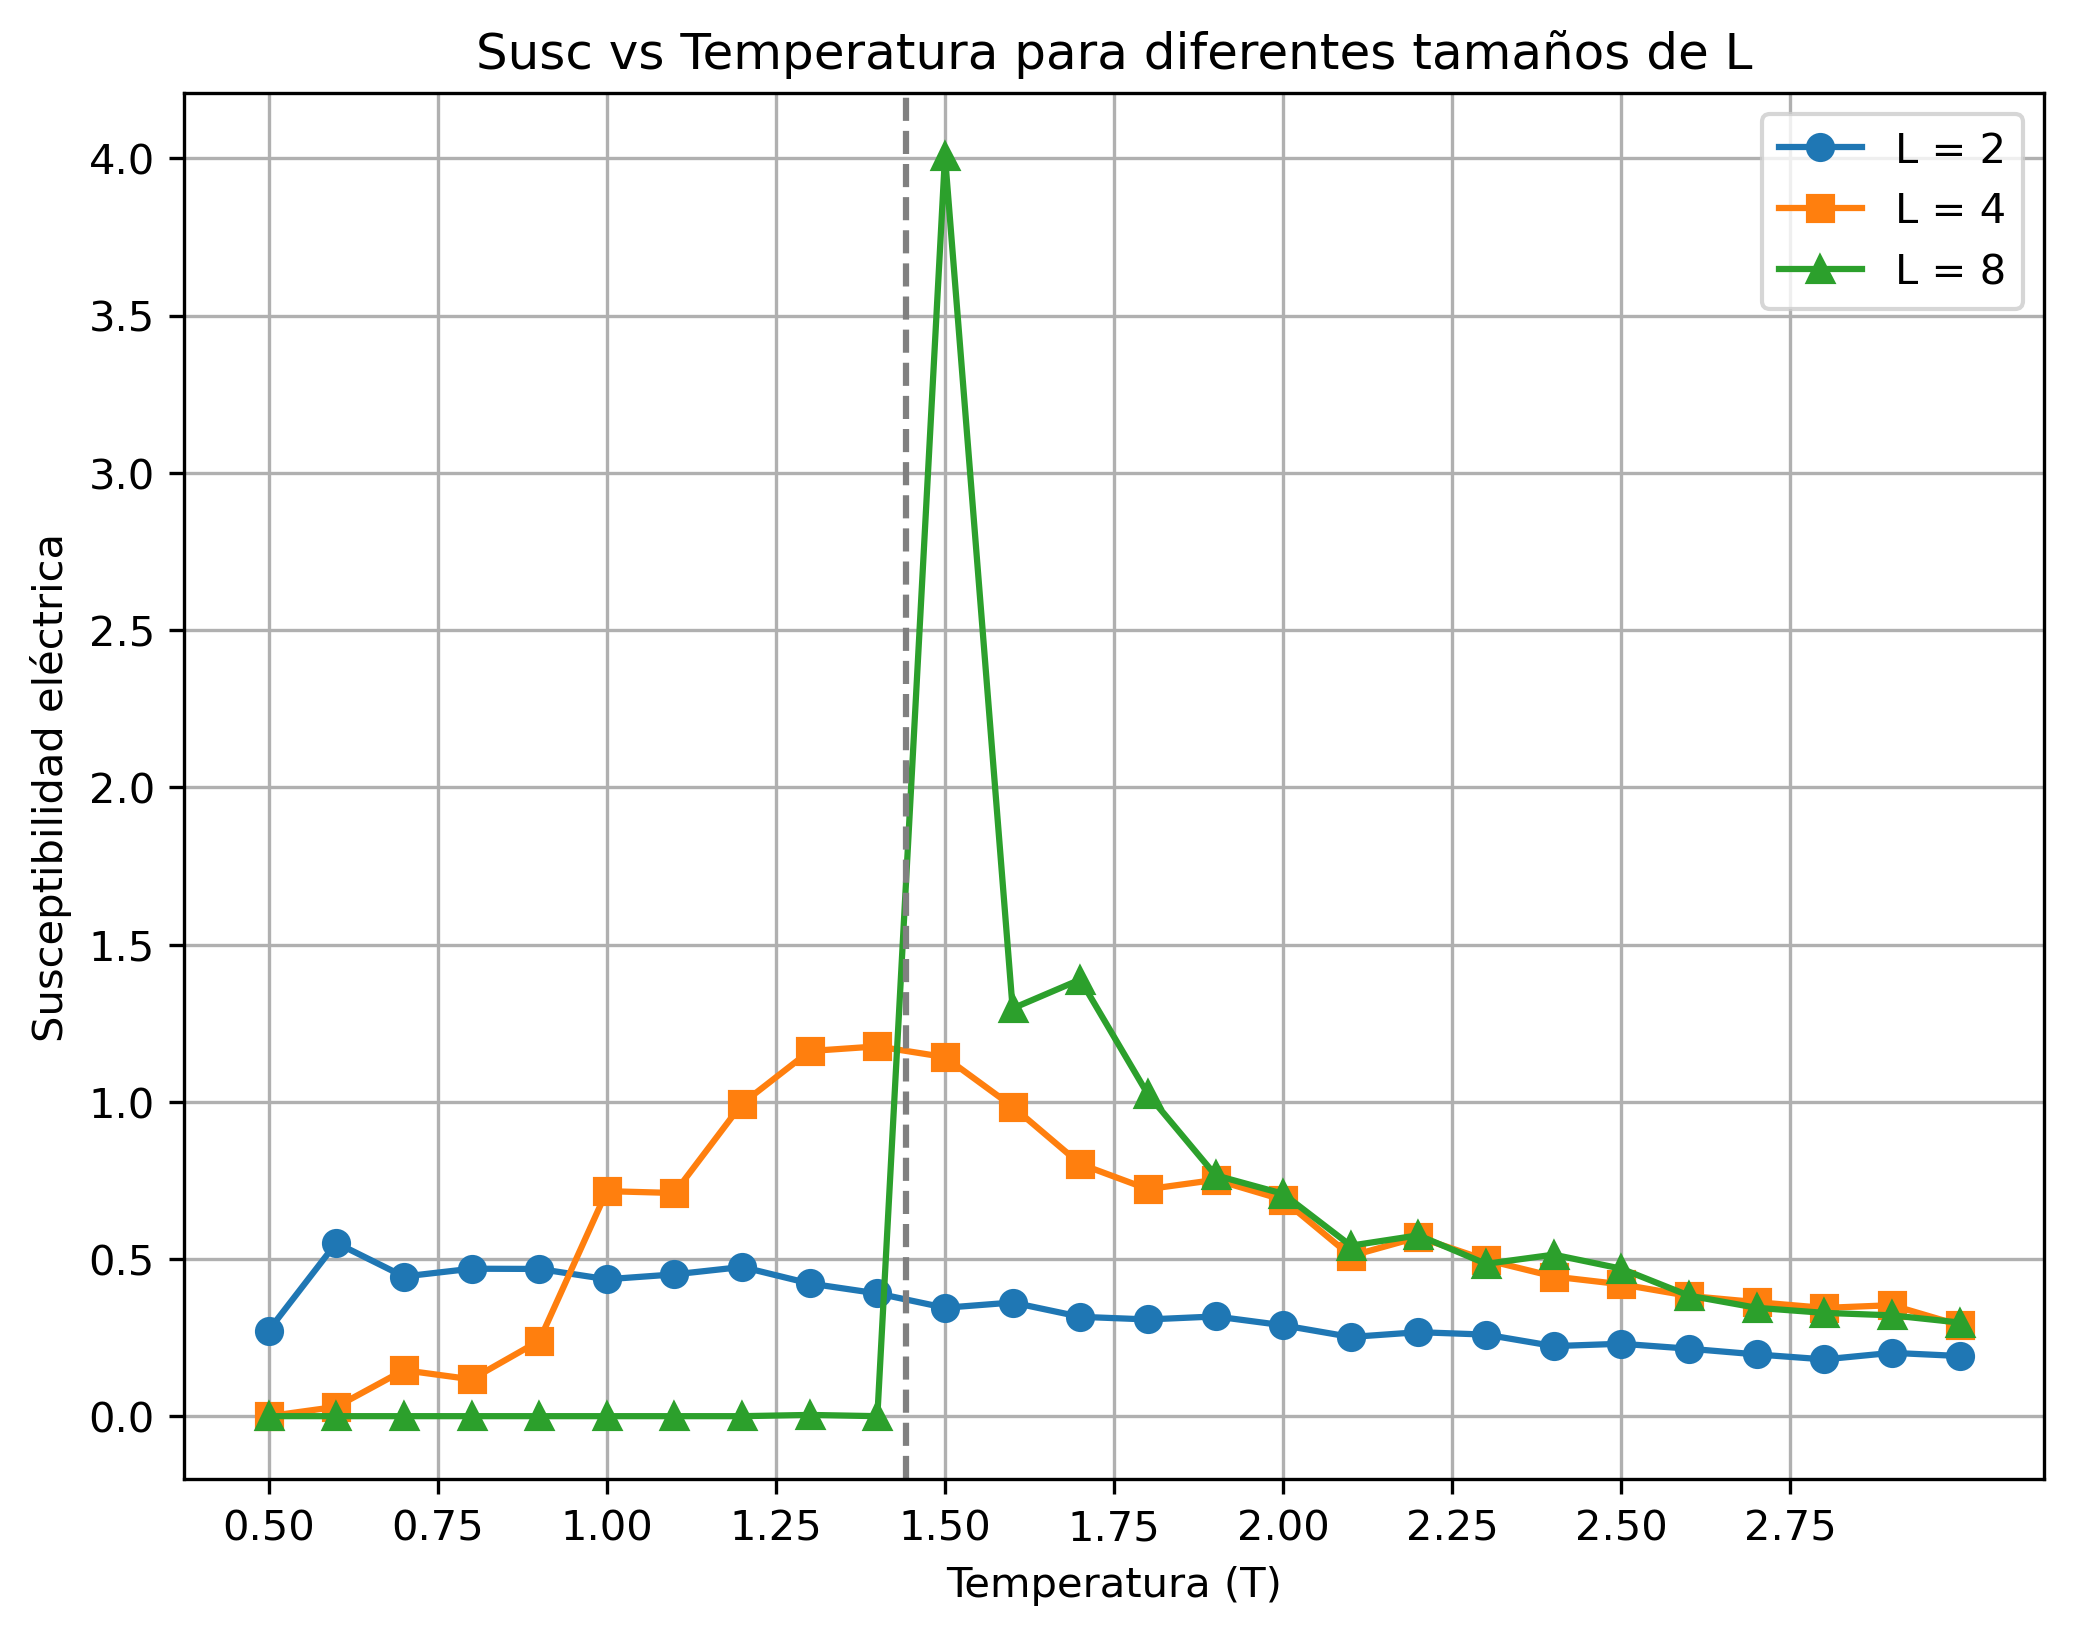

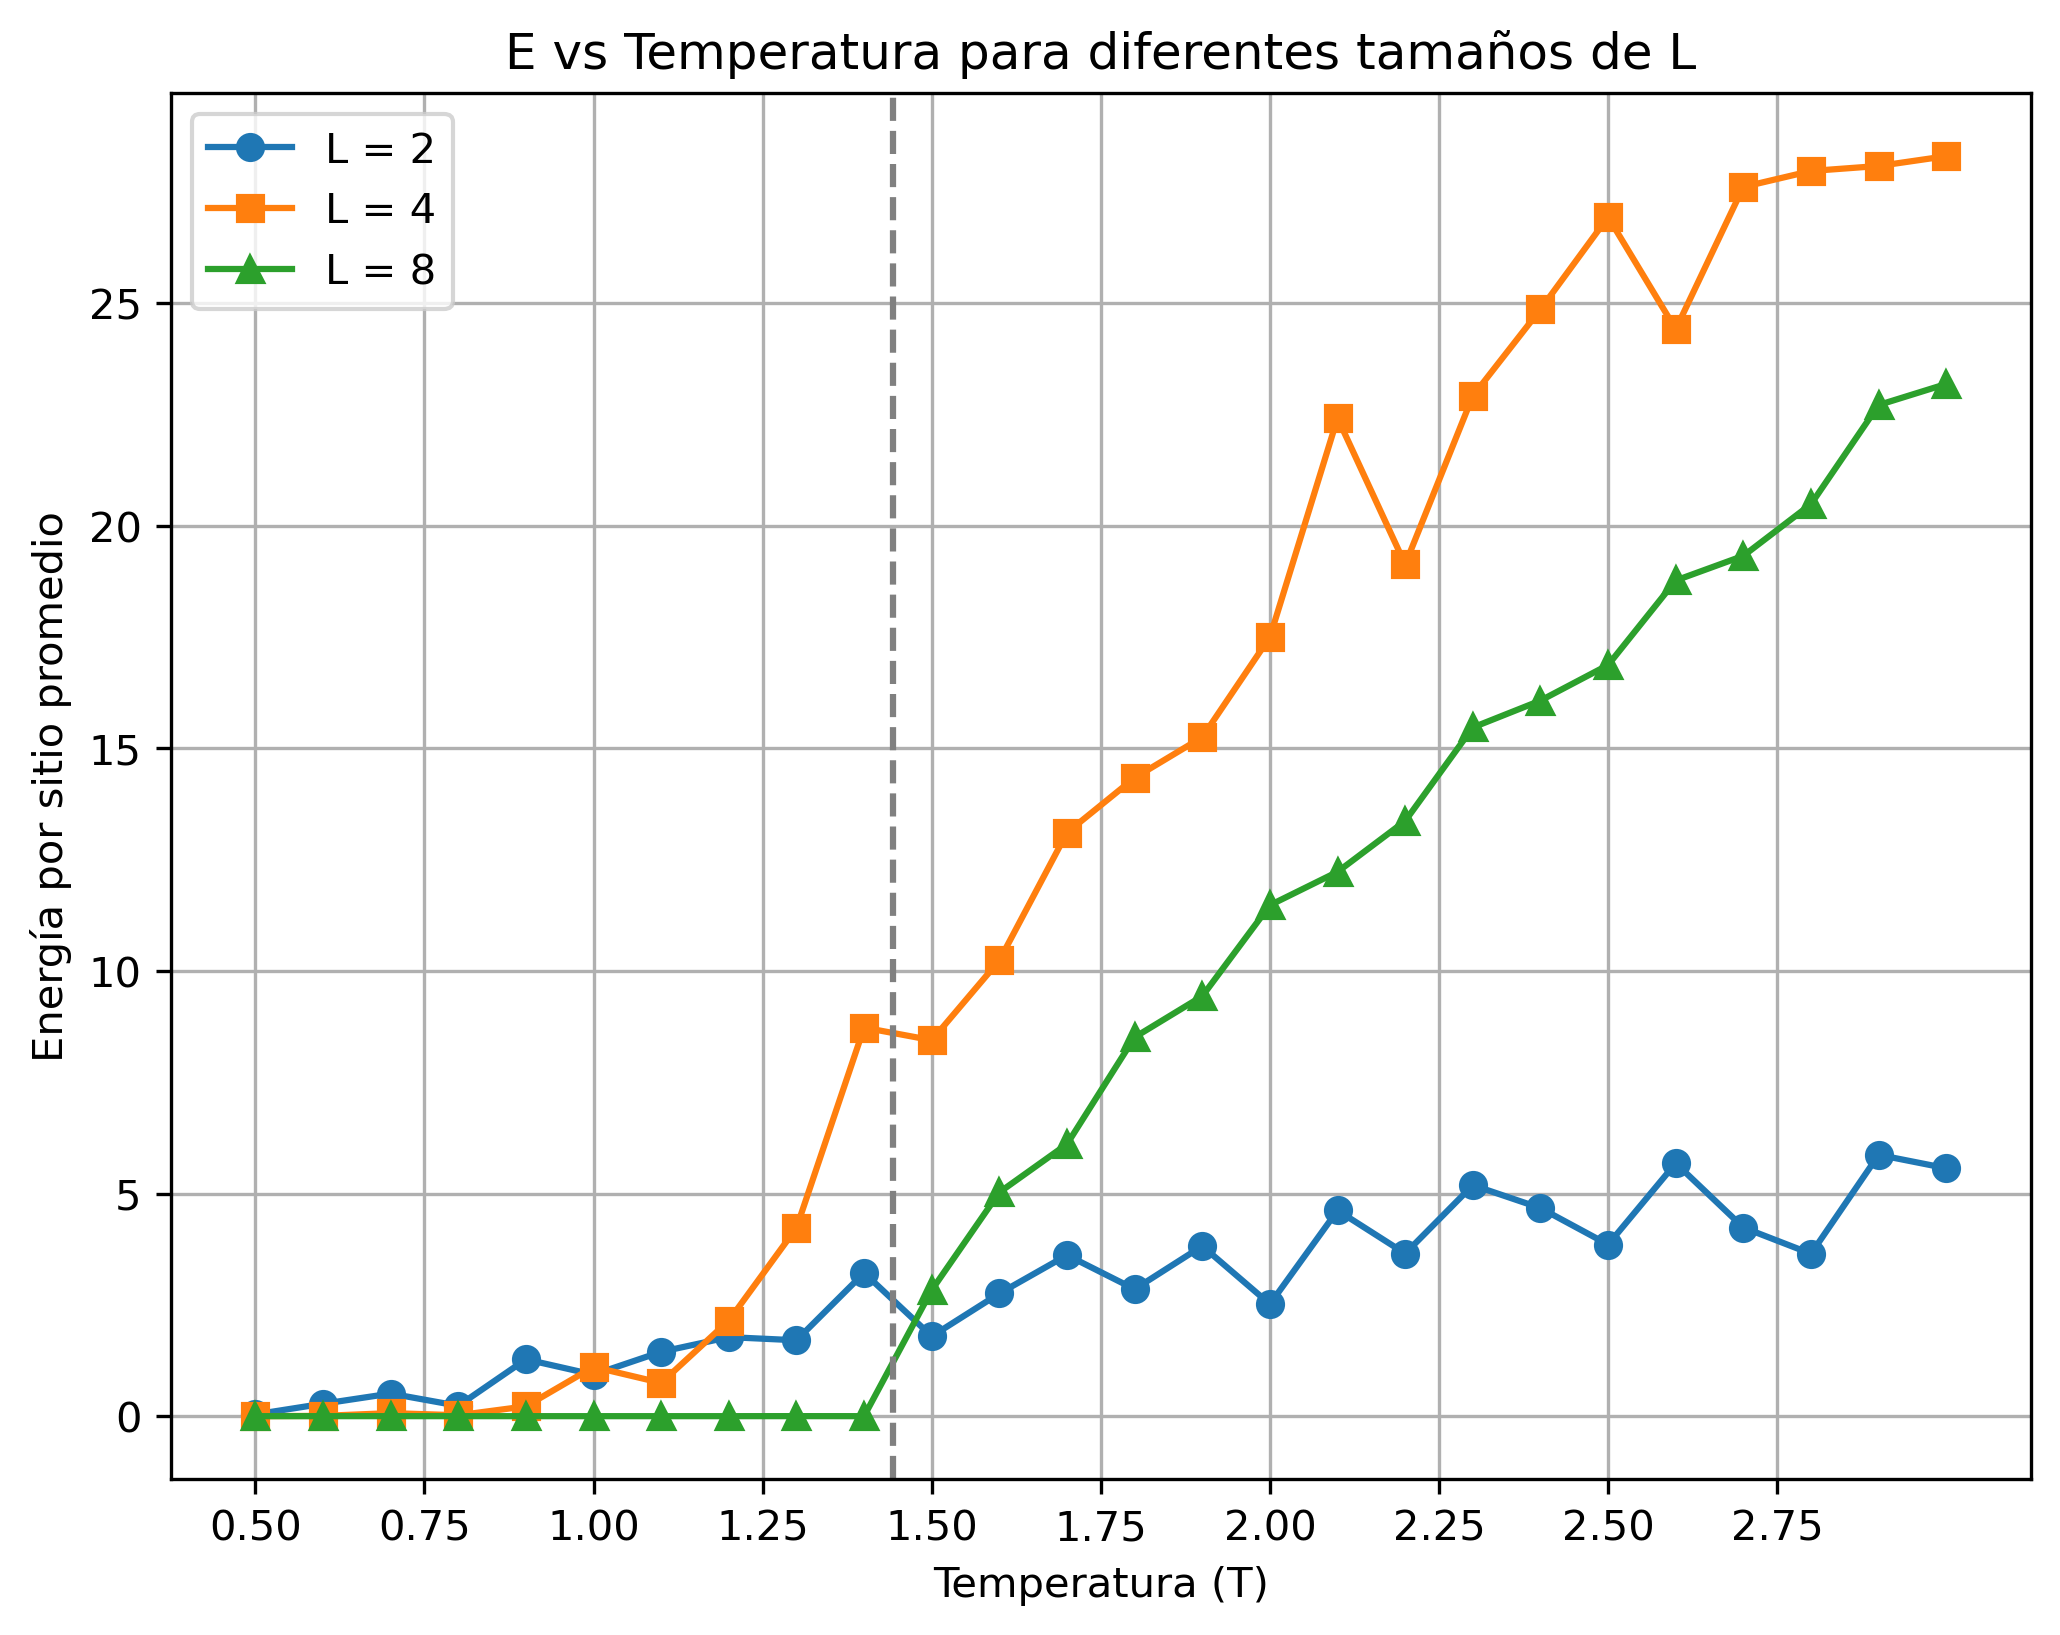

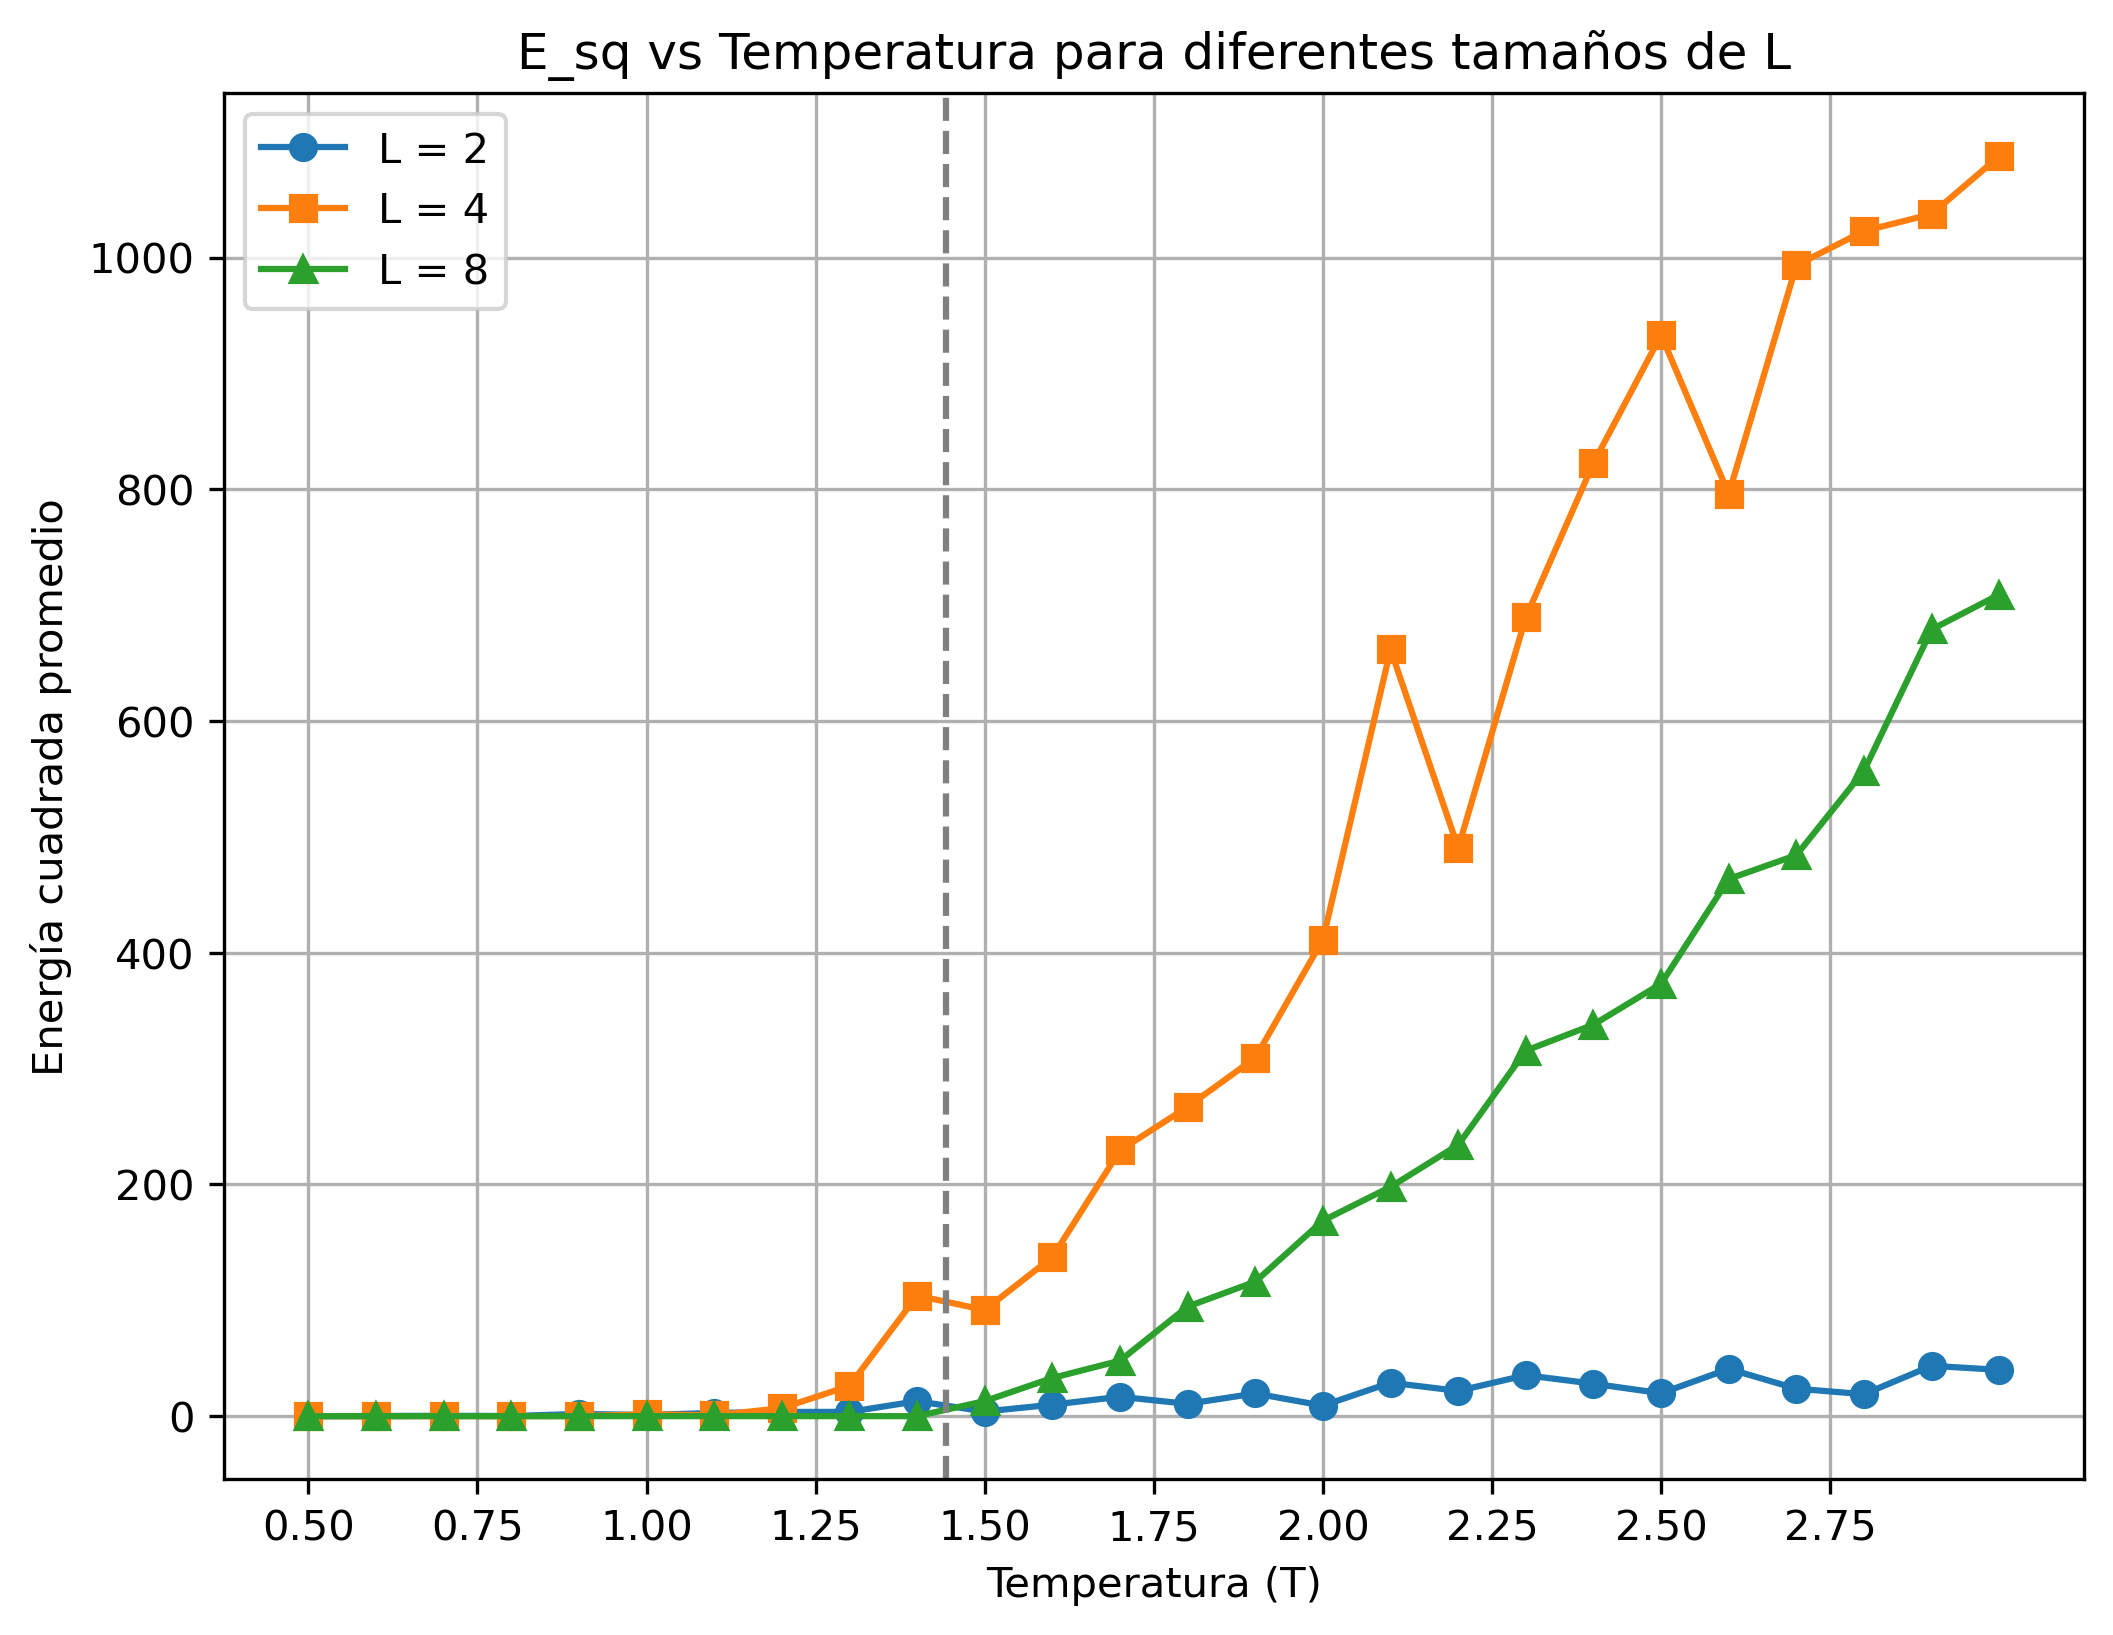

5417.764758825302


In [3]:
#Resultados de la tesis
ini = time.time()
tamaño = [2, 4, 8] #Definimos una lista con tamaños de L
marcadores = ['o', 's', '^'] #Definimos los distintos marcadores de la gráfica 


fig1, ax1 = plt.subplots(figsize=(8, 6), dpi=300)  # Figura para Polarización
fig2, ax2 = plt.subplots(figsize=(8, 6), dpi=300)  # Figura para Susceptibilidad
fig3, ax3 = plt.subplots(figsize=(8, 6), dpi=300)  # Figura para Energia
fig4, ax4 = plt.subplots(figsize=(8, 6), dpi=300) #Figura para energia cuadrada


for lado, marcador in zip(tamaño, marcadores):
    print(f"Realizando la simulación de la lattice de tamaño {lado}...")
    simul = SixVertexModelArrows(L=lado, pasos_eq=100, mc_pasos=1000)
    temp, etot_avg, etotsq_avg, mabstot_avg, sustot_avg = simul.experimentos_mc()
    ax1.plot(temp, mabstot_avg, label=f"L = {simul.L}", linestyle='-', marker=marcador)
    ax2.plot(temp, sustot_avg, label=f"L = {simul.L}", linestyle='-', marker=marcador)
    ax3.plot(temp, etot_avg, label=f"L = {simul.L}", linestyle='-', marker=marcador)
    ax4.plot(temp, etotsq_avg, label=f"L = {simul.L}", linestyle='-', marker=marcador)
    print(f"Simulación de tamaño {lado} terminada")

ax1.set_xlabel("Temperatura (T)")
ax1.set_ylabel("Polarización absoluta promedio")
ax1.set_title("Polarización absoluta promedio vs Temperatura para diferentes tamaños de L")
ax1.legend()
ax1.grid()
ax1.set_xticks(np.arange(min(temp), max(temp), step=(max(temp) - min(temp))/10))  # 10 divisiones en el eje X

ax2.set_xlabel("Temperatura (T)")
ax2.set_ylabel("Susceptibilidad eléctrica")
ax2.set_title("Susc vs Temperatura para diferentes tamaños de L")
ax2.legend()
ax2.grid()
ax2.set_xticks(np.arange(min(temp), max(temp), step=(max(temp) - min(temp))/10))  # 10 divisiones en el eje X

ax3.set_xlabel("Temperatura (T)")
ax3.set_ylabel("Energía por sitio promedio")
ax3.set_title("E vs Temperatura para diferentes tamaños de L")
ax3.legend()
ax3.grid()
ax3.set_xticks(np.arange(min(temp), max(temp), step=(max(temp) - min(temp))/10))  # 10 divisiones en el eje X

ax4.set_xlabel("Temperatura (T)")
ax4.set_ylabel("Energía cuadrada promedio")
ax4.set_title("E_sq vs Temperatura para diferentes tamaños de L")
ax4.legend()
ax4.grid()
ax4.set_xticks(np.arange(min(temp), max(temp), step=(max(temp) - min(temp))/10))  # 10 divisiones en el eje X

ax1.axvline(x = 1.443, color = 'grey', linestyle='--', label = 'T_c = 1.442...')
ax2.axvline(x = 1.443, color = 'grey', linestyle='--', label = 'T_c = 1.442...')
ax3.axvline(x = 1.443, color = 'grey', linestyle='--', label = 'T_c = 1.442...')
ax4.axvline(x = 1.443, color = 'grey', linestyle='--', label = 'T_c = 1.442...')

plt.show()
fin = time.time()
print(fin-ini)